### Basic ISC



#### Import modules

In [38]:
#!pip install nilearn surfplot 
#!pip install panel
#!pip install neuromaps

import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob,shutil
from nilearn import plotting, maskers, datasets
import numpy as np
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import view_img_on_surf, view_img
from nltools.stats import isc, threshold, fdr
from tqdm import tqdm

import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
warnings.simplefilter("ignore")

#### Setup variables and filenames

In [39]:
recompute_results      = True
pairwise_flag          = True
n_iter1                = 5000
n_iter                 = 1000
alpha                  = 0.05
twin_data_file         = '../data/00_dataset_info/twin_df.csv'
fmri_data_file         = '../data/03_extract_ts_aus/ts_array_shen268_pauli16_aan9.npy'
all293_rois_file       = '../data/02_rois_masks_maps/allcombined.nii'
masker_prefitting_file = '../data/02_rois_masks_maps/func.nii.gz'

isc_result_file_phase  = '../data/05_results/aus_isc_phase1000FDRq05.nii'
isc_result_file_perm   = '../data/05_results/aus_isc_perm1000_FDRq05.nii'
isc_npy_file           = '../data/05_results/aus_isc_perm1000_FDRq05.npy'


#### Load viewer info, set up masker, load timeseries

In [40]:
# load subject info
twin_df = pd.read_csv(twin_data_file)
sub_list = list(np.hstack((twin_df['twin_A_id'].values, twin_df['twin_B_id'].values)))
print("Number of subjects: " + str(len(sub_list)))

# prepare masker
isc_masker            = maskers.NiftiLabelsMasker(all293_rois_file);
isc_masker.fit(masker_prefitting_file);
print("Set up ISC masker")

# load timeseries, swap axes
ts_array = np.load(fmri_data_file)
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)
print("Shape of time series structure: " + str(ts_data.shape))

Number of subjects: 200
Set up ISC masker
Shape of time series structure: (380, 293, 200)


#### Basic ISC analysis 
(via resampling stats)

In [41]:
# set up mask
mask = Brain_Data(all293_rois_file)
mask_x = expand_mask(mask)

# run isc permutation/bootstrap analysis
p_results = []
isc_results = []
for curr_roi in tqdm(range(293)):
    #print(curr_roi)
    data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )
    stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True)
    #print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
    p_results.append(stats_boot['p'])
    isc_results.append(stats_boot['isc'])

100%|███████████████████████████████████████████████████████████████████████████████████| 293/293 [02:10<00:00,  2.25it/s]


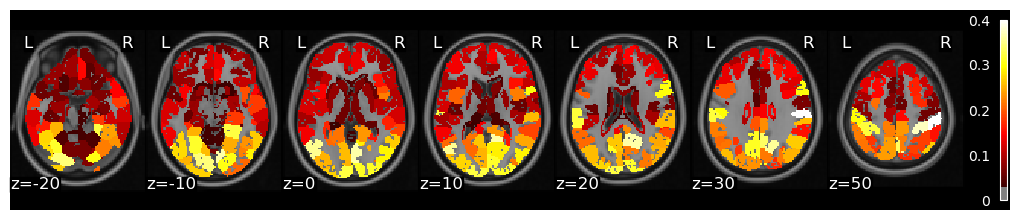

In [42]:
# map isc results back to brain
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_results), mask_x), roi_to_brain(pd.Series(p_results), mask_x)
result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data, q = alpha)).to_nifti()

# visualize results
fig = plt.figure(figsize=(10, 2))
nilearn.plotting.plot_stat_map(    result_image, 
                                   bg_img       = '../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20, 30, 50],
                                   annotate     = True,
                                   figure = fig);


#### Compute and Plot ISC (Phase Randomization)

Now computing phaseshift ISC ...


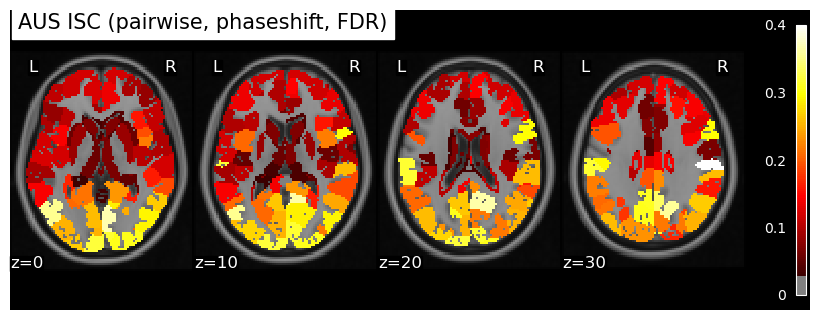

In [45]:
if recompute_results:
    
    # submit to ISC analysis, takes about 15-20 minutes on normal machine with 1000 shifts
    print('Now computing phaseshift ISC ...')
    ISC, p = partly_phaseshift_isc(ts_data, pairwise = pairwise_flag, summary_statistic = np.median,
                                    n_shifts = n_iter, return_distribution = False)
    ISC[np.isnan(ISC)] = 0
    
    # Stats correction 
    q                               = multipletests(p[0, :], method='fdr_by')[1]
    corrected                       = q[np.newaxis, :] < alpha
    ISC[corrected == False]         = 0

    # Map to brain space
    curr_isc = np.reshape(ISC, (293,1)).T
    curr_img = isc_masker.inverse_transform(curr_isc);
    curr_img.to_filename(isc_result_file_phase)

else:
    curr_img = nilearn.image.load_img(isc_result_file_phase)

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.03, 
                                   bg_img       = '../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ 0, 10, 20, 30],
                                   annotate     = True,
                                   title = 'AUS ISC (pairwise, phaseshift, FDR)',
                                   figure = fig);
plt.show();

#### Compute and Plot ISC (Permutation)

Assuming 200 subjects with 380 time points and 293 voxel(s) or ROI(s).
Now computing permutation ISC ...


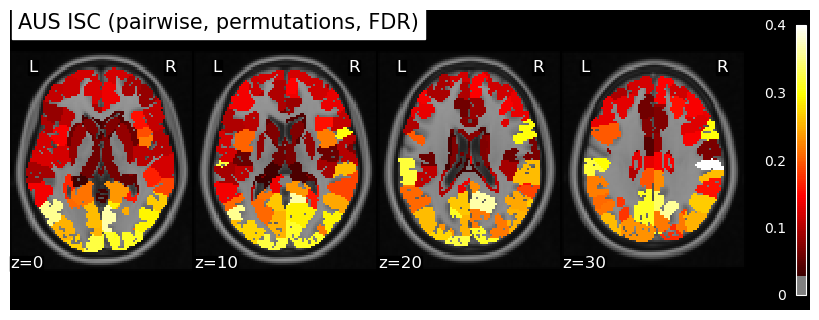

In [47]:
if recompute_results:
    
    # first, compute the individual isc and flatten into a one-subject-per-line matrix 
    input_isc = partly_isc(ts_data, pairwise=True, summary_statistic=None)
    
    # Compute permutation ISC
    print('Now computing permutation ISC ...')
    ISC, p, distribution = partly_permutation_isc(input_isc, pairwise= True, summary_statistic = 'median', n_permutations = n_iter)
    
    # Correction 
    p = np.reshape(p, (293,1)).T
    ISC[np.isnan(ISC)]      = 0
    q                       = multipletests(p[0, :], method='fdr_by')[1]
    corrected               = q[np.newaxis, :] < alpha
    ISC[corrected == False] = 0

    # Map statistical results into brain space
    curr_isc = np.reshape(ISC, (293,1)).T
    curr_img = isc_masker.inverse_transform(curr_isc);
    curr_img.to_filename(isc_result_file_perm)
    np.save(isc_npy_file, curr_isc)

else:
    curr_img = nilearn.image.load_img(isc_result_file_perm)

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                       bg_img       = '../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                       threshold    = 0.03, 
                                       vmax         = 0.4, 
                                       draw_cross   = False,
                                       display_mode = 'z',
                                       cut_coords   = [ 0, 10, 20, 30],
                                       annotate     = True,
                                       title = 'AUS ISC (pairwise, permutations, FDR)',
                                       figure = fig);
plt.show();

#### Additionally, take a far more conservative approach

Assuming 200 subjects with 380 time points and 293 voxel(s) or ROI(s).
Now computing permutation ISC ...


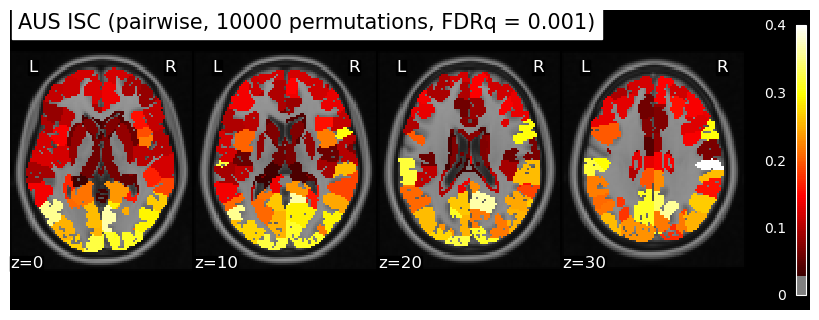

In [48]:
    
# first, compute the individual isc and flatten into a one-subject-per-line matrix 
input_isc = partly_isc(ts_data, pairwise=True, summary_statistic=None)
    
# Compute permutation ISC
print('Now computing permutation ISC ...')
ISC, p, distribution = partly_permutation_isc(input_isc, pairwise= True, summary_statistic = 'median', n_permutations = 10000)
    
# Correction 
p = np.reshape(p, (293,1)).T
ISC[np.isnan(ISC)]      = 0
q                       = multipletests(p[0, :], method='fdr_by')[1]
corrected               = q[np.newaxis, :] < 0.001
ISC[corrected == False] = 0

# Map statistical results into brain space
curr_isc = np.reshape(ISC, (293,1)).T
curr_img = isc_masker.inverse_transform(curr_isc);

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                       bg_img       = '../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                       threshold    = 0.03, 
                                       vmax         = 0.4, 
                                       draw_cross   = False,
                                       display_mode = 'z',
                                       cut_coords   = [ 0, 10, 20, 30],
                                       annotate     = True,
                                       title = 'AUS ISC (pairwise, 10000 permutations, FDRq = 0.001)',
                                       figure = fig);
plt.show();

#### Additional explorations of variants of computing and testing ISC

In [49]:
curr_roi    = 47
data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )

In [50]:
stats_circle = isc(data_roi_df, method='circle_shift', n_samples=5000, return_null=True)

print(f"ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")

ISC: 0.27, p = 0.0002


In [51]:
stats_phase = isc(data_roi_df, method='phase_randomize', n_samples=5000, return_null=True)

print(f"ISC: {stats_phase['isc']:.02}, p = {stats_phase['p']:.03}")

ISC: 0.27, p = 0.0002


In [52]:
stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True)

print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

ISC: 0.27, p = 0.0002


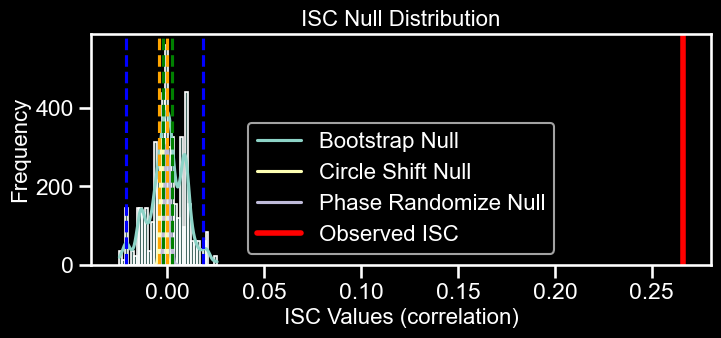

In [56]:
fs = 16

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

plt.figure(figsize=(8,3));
sns.histplot(stats_boot['null_distribution'] - stats_boot['isc'], kde=True, label='Bootstrap');
sns.histplot(stats_circle['null_distribution'], kde=True, label='Bootstrap');
sns.histplot(stats_phase['null_distribution'], kde=True, label='Bootstrap');
plt.ylabel('Frequency', fontsize= fs);
plt.xlabel('ISC Values (correlation)', fontsize= fs);
plt.title('ISC Null Distribution', fontsize= fs);
plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4);
plt.legend(['Bootstrap Null','Circle Shift Null', 'Phase Randomize Null', 'Observed ISC'], fontsize=fs);
    
plt.axvline(stats_boot['ci'][0] - stats_boot['isc'], linestyle='--', color='blue');
plt.axvline(stats_boot['ci'][1] - stats_boot['isc'], linestyle='--', color='blue');
    
plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange');
plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange');
    
plt.axvline(stats_phase['ci'][0], linestyle='--', color='green');
plt.axvline(stats_phase['ci'][1], linestyle='--', color='green');
plt.show()

0
ISC: 0.062, p = 0.0002


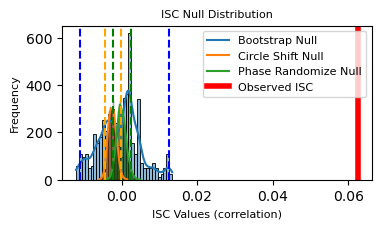

1
ISC: 0.075, p = 0.0002


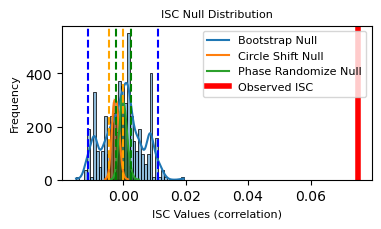

2
ISC: 0.15, p = 0.0002


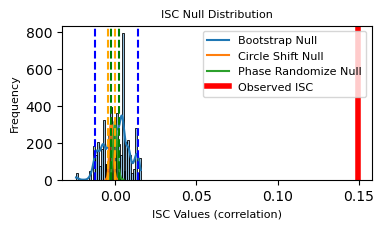

3
ISC: 0.048, p = 0.0002


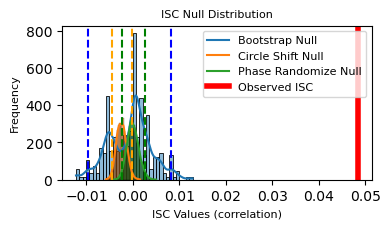

4
ISC: 0.14, p = 0.0002


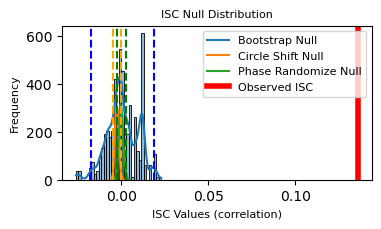

5
ISC: 0.12, p = 0.0002


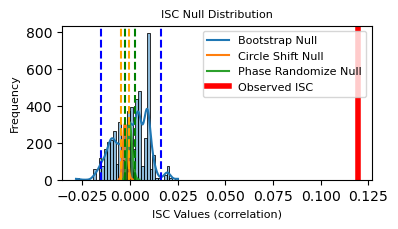

6
ISC: 0.095, p = 0.0002


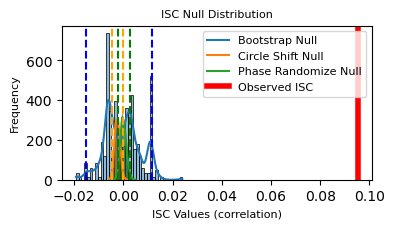

7
ISC: 0.082, p = 0.0002


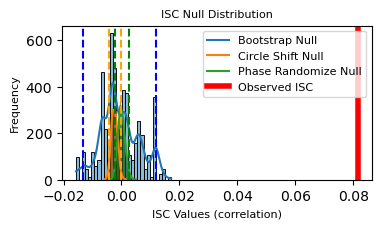

8
ISC: 0.12, p = 0.0002


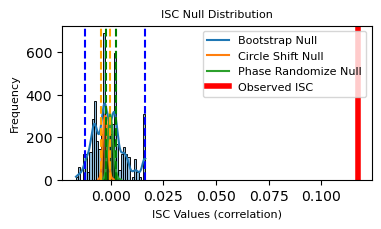

9
ISC: 0.14, p = 0.0002


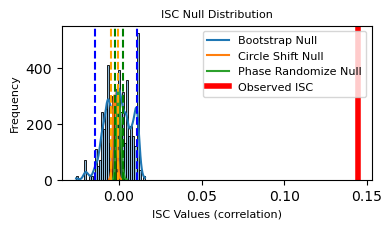

10
ISC: 0.14, p = 0.0002


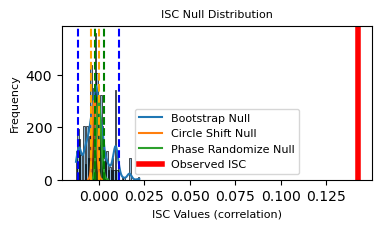

11
ISC: 0.13, p = 0.0002


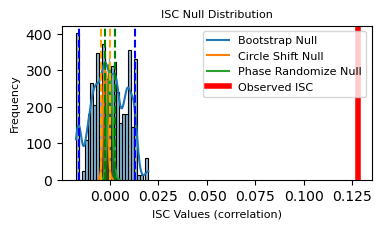

12
ISC: 0.15, p = 0.0002


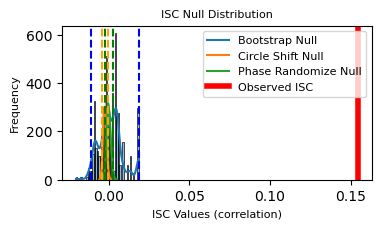

13
ISC: 0.12, p = 0.0002


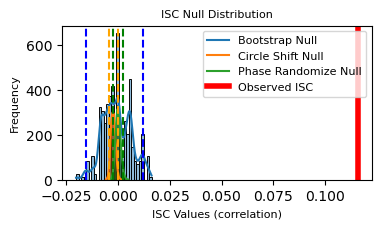

14
ISC: 0.071, p = 0.0002


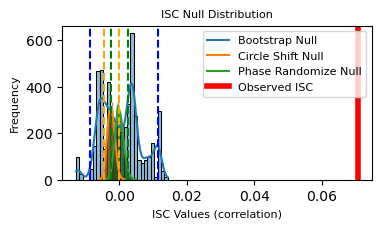

15
ISC: 0.11, p = 0.0002


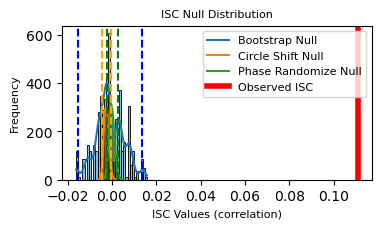

16
ISC: 0.072, p = 0.0002


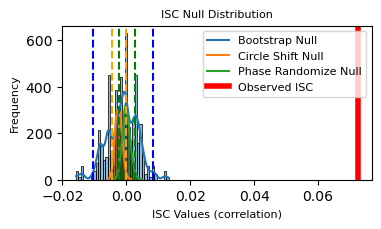

17
ISC: 0.056, p = 0.0002


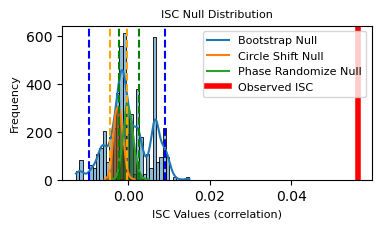

18
ISC: 0.13, p = 0.0002


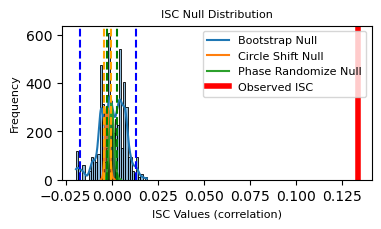

19
ISC: 0.16, p = 0.0002


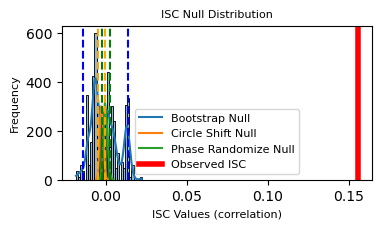

20
ISC: 0.3, p = 0.0002


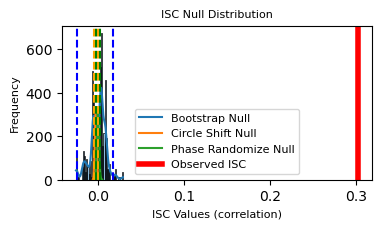

21
ISC: 0.13, p = 0.0002


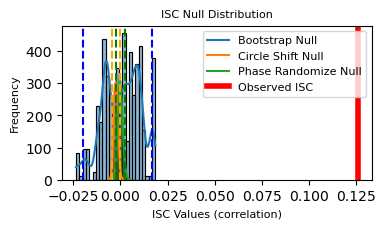

22
ISC: 0.066, p = 0.0002


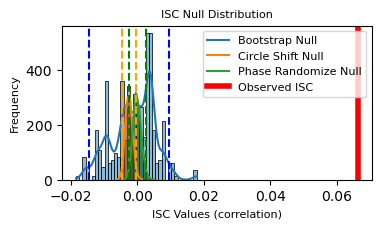

23
ISC: 0.072, p = 0.0002


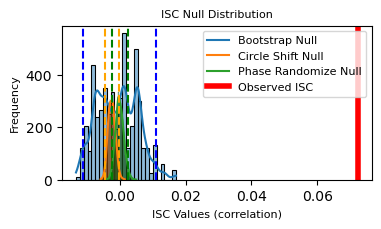

24
ISC: 0.059, p = 0.0002


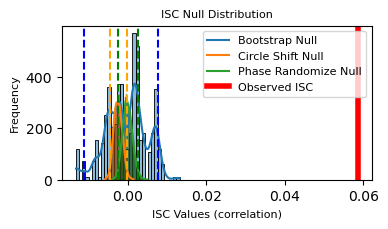

25
ISC: 0.16, p = 0.0002


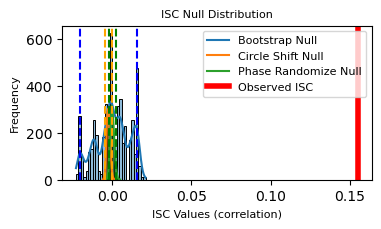

26
ISC: 0.072, p = 0.0002


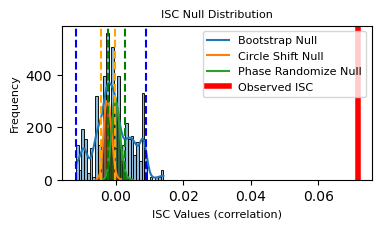

27
ISC: 0.086, p = 0.0002


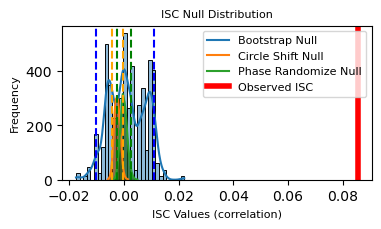

28
ISC: 0.13, p = 0.0002


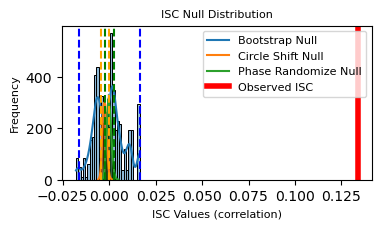

29
ISC: 0.16, p = 0.0002


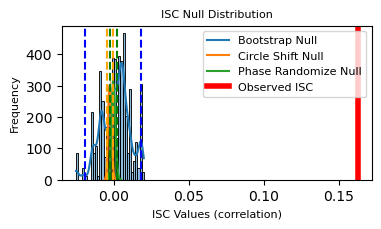

30
ISC: 0.14, p = 0.0002


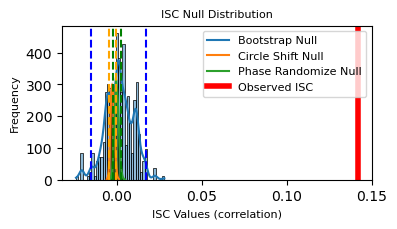

31
ISC: 0.17, p = 0.0002


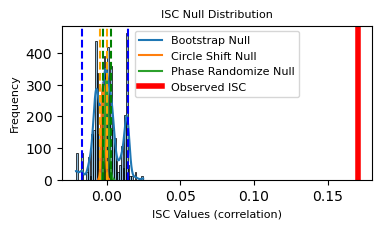

32
ISC: 0.062, p = 0.0002


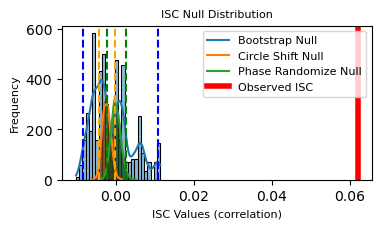

33
ISC: 0.19, p = 0.0002


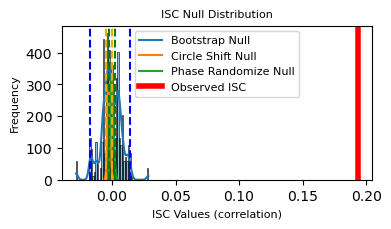

34
ISC: 0.22, p = 0.0002


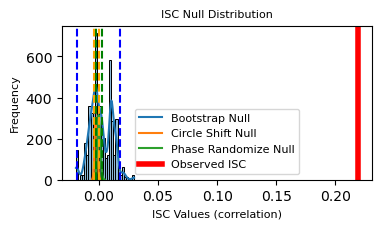

35
ISC: 0.11, p = 0.0002


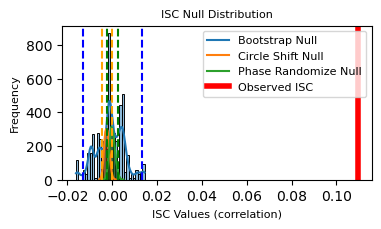

36
ISC: 0.11, p = 0.0002


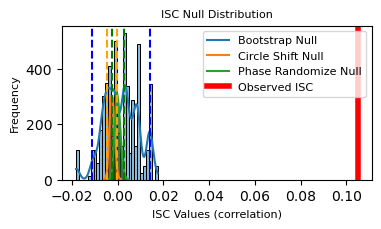

37
ISC: 0.37, p = 0.0002


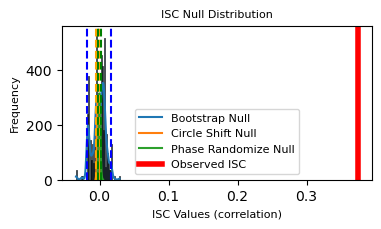

38
ISC: 0.095, p = 0.0002


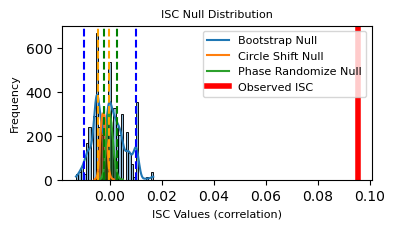

39
ISC: 0.057, p = 0.0002


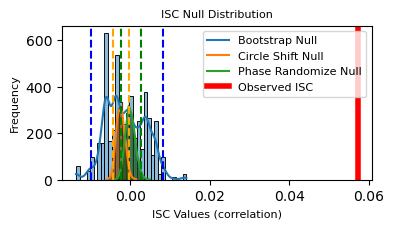

40
ISC: 0.26, p = 0.0002


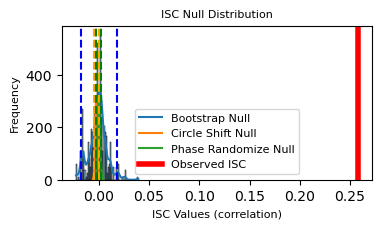

41
ISC: 0.36, p = 0.0002


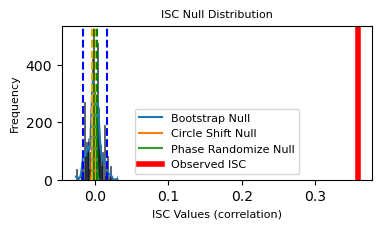

42
ISC: 0.18, p = 0.0002


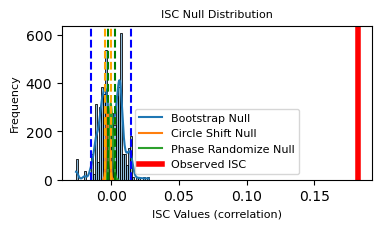

43
ISC: 0.22, p = 0.0002


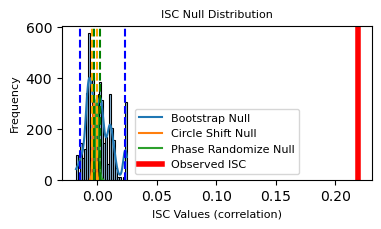

44
ISC: 0.43, p = 0.0002


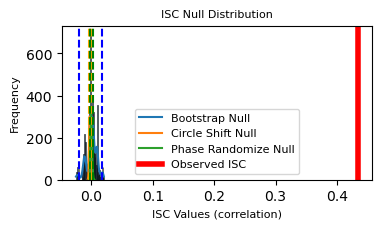

45
ISC: 0.26, p = 0.0002


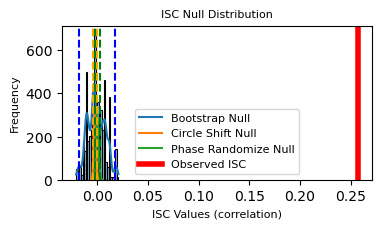

46
ISC: 0.16, p = 0.0002


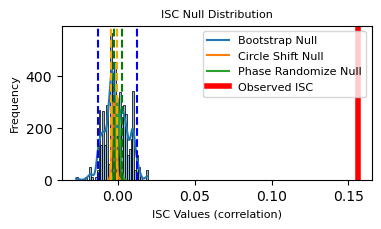

47
ISC: 0.27, p = 0.0002


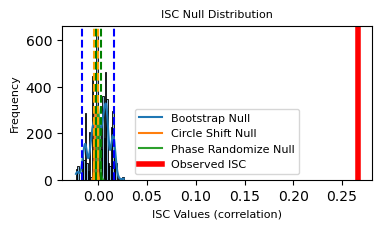

48
ISC: 0.25, p = 0.0002


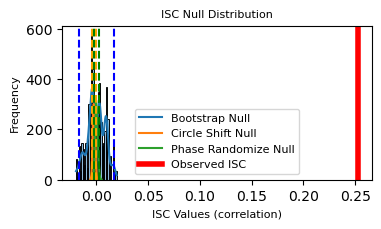

49
ISC: 0.24, p = 0.0002


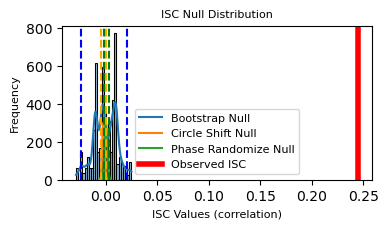

50
ISC: 0.064, p = 0.0002


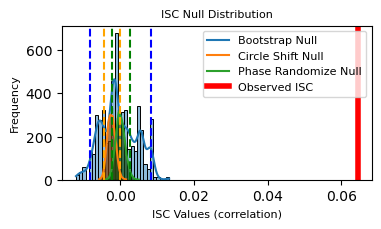

51
ISC: 0.14, p = 0.0002


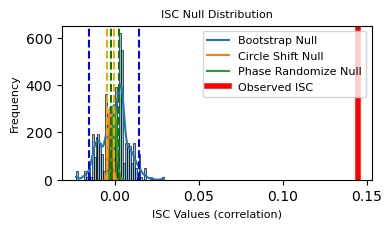

52
ISC: 0.15, p = 0.0002


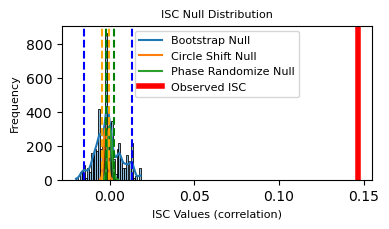

53
ISC: 0.16, p = 0.0002


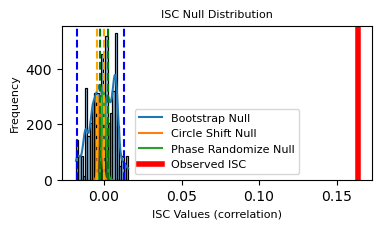

54
ISC: 0.12, p = 0.0002


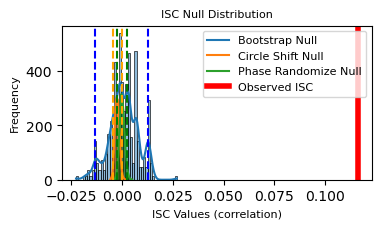

55
ISC: 0.083, p = 0.0002


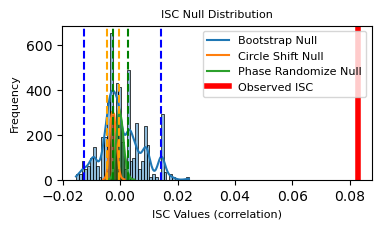

56
ISC: 0.13, p = 0.0002


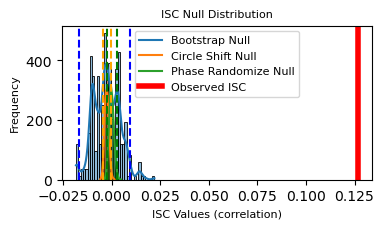

57
ISC: 0.072, p = 0.0002


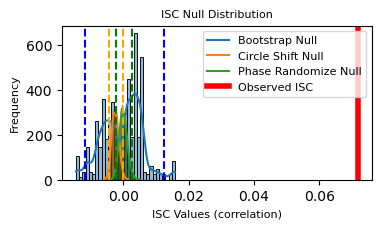

58
ISC: 0.12, p = 0.0002


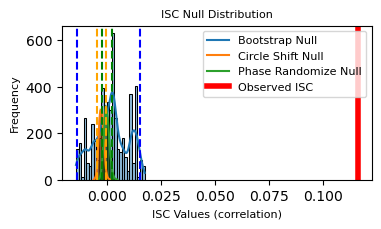

59
ISC: 0.065, p = 0.0002


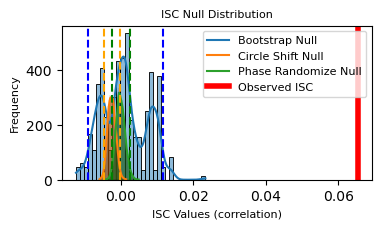

60
ISC: 0.1, p = 0.0002


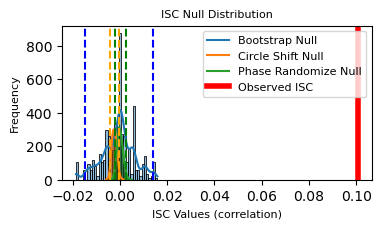

61
ISC: 0.093, p = 0.0002


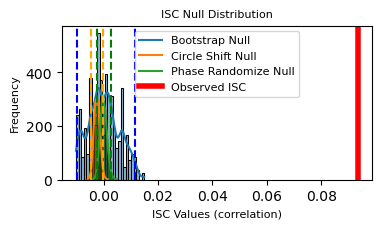

62
ISC: 0.12, p = 0.0002


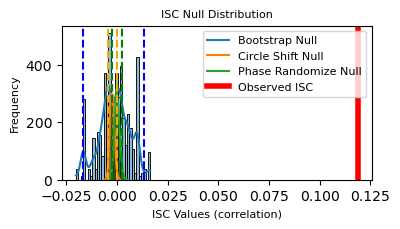

63
ISC: 0.18, p = 0.0002


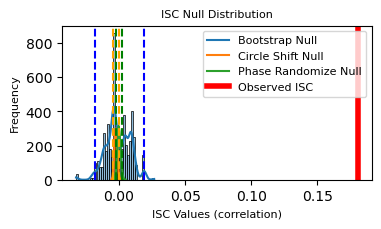

64
ISC: 0.19, p = 0.0002


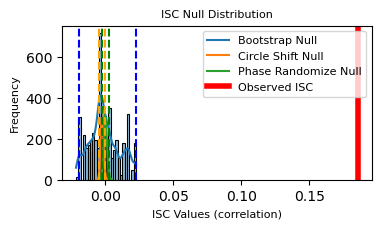

65
ISC: 0.23, p = 0.0002


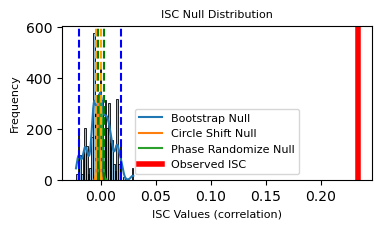

66
ISC: 0.22, p = 0.0002


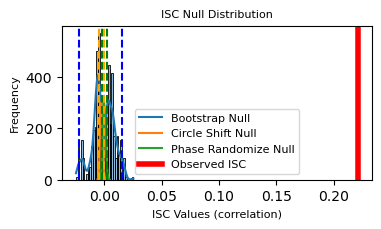

67
ISC: 0.32, p = 0.0002


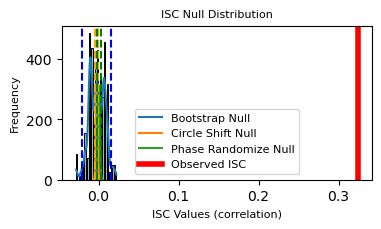

68
ISC: 0.27, p = 0.0002


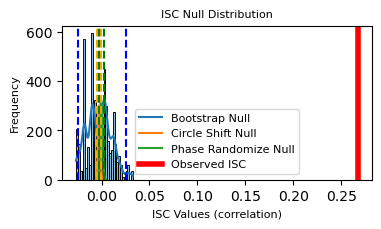

69
ISC: 0.1, p = 0.0002


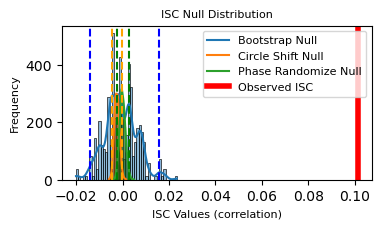

70
ISC: 0.24, p = 0.0002


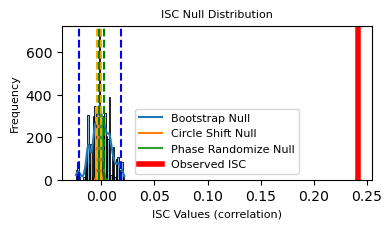

71
ISC: 0.25, p = 0.0002


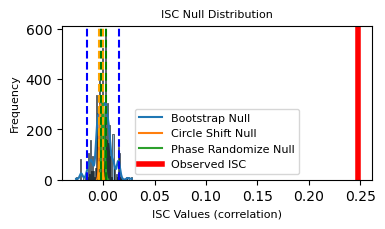

72
ISC: 0.22, p = 0.0002


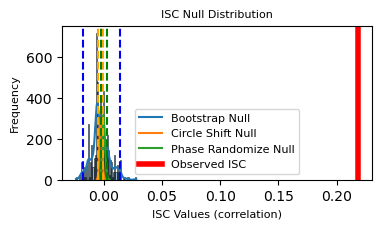

73
ISC: 0.29, p = 0.0002


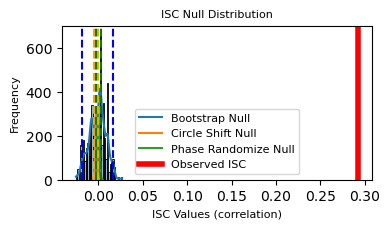

74
ISC: 0.17, p = 0.0002


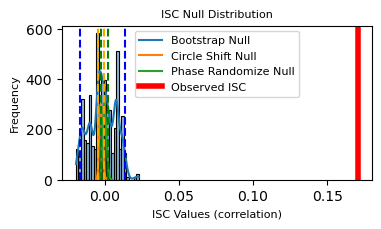

75
ISC: 0.3, p = 0.0002


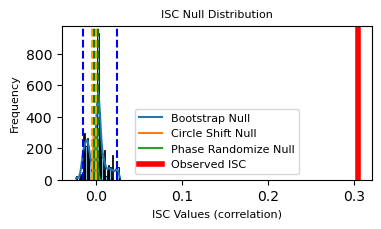

76
ISC: 0.22, p = 0.0002


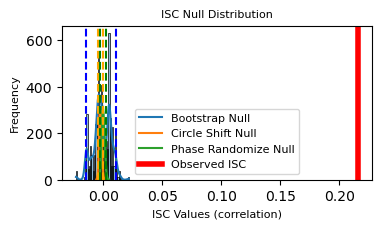

77
ISC: 0.31, p = 0.0002


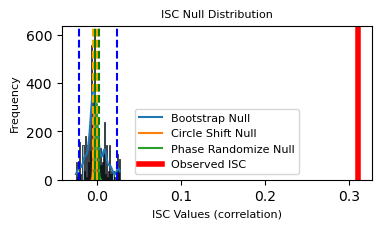

78
ISC: 0.37, p = 0.0002


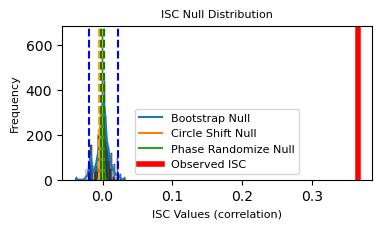

79
ISC: 0.31, p = 0.0002


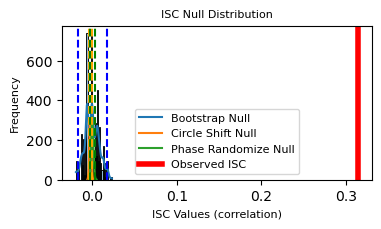

80
ISC: 0.21, p = 0.0002


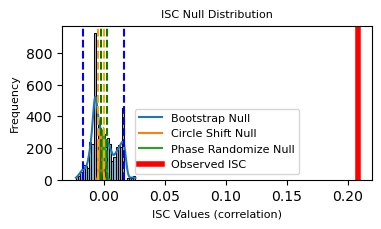

81
ISC: 0.29, p = 0.0002


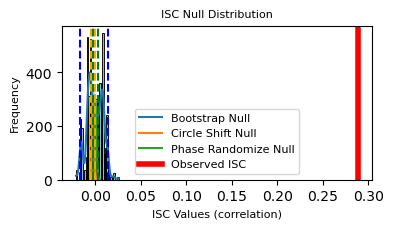

82
ISC: 0.086, p = 0.0002


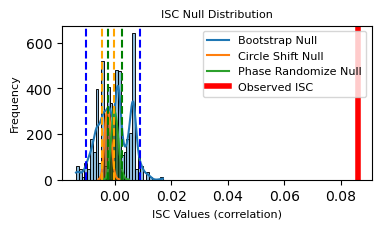

83
ISC: 0.08, p = 0.0002


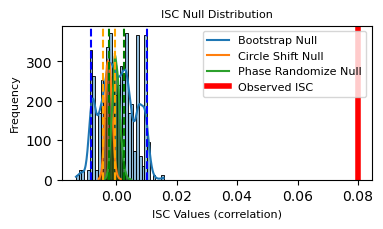

84
ISC: 0.23, p = 0.0002


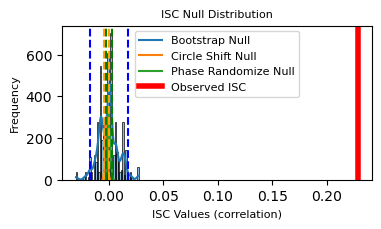

85
ISC: 0.36, p = 0.0002


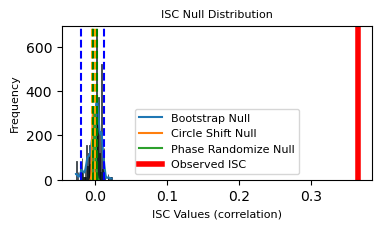

86
ISC: 0.16, p = 0.0002


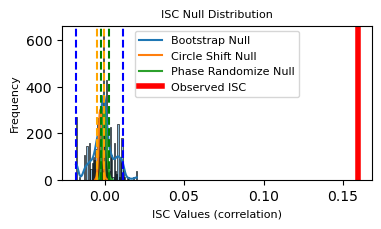

87
ISC: 0.14, p = 0.0002


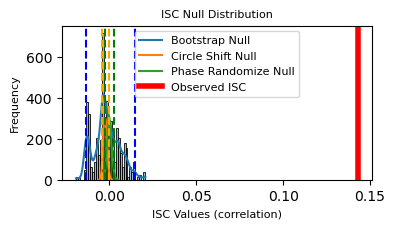

88
ISC: 0.15, p = 0.0002


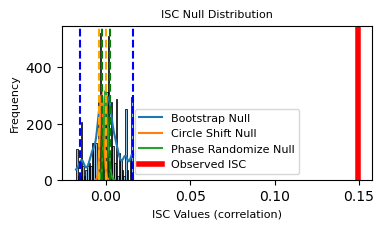

89
ISC: 0.33, p = 0.0002


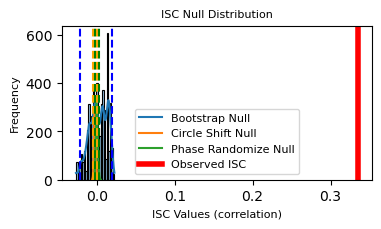

90
ISC: 0.24, p = 0.0002


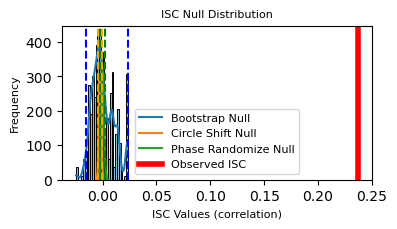

91
ISC: 0.072, p = 0.0002


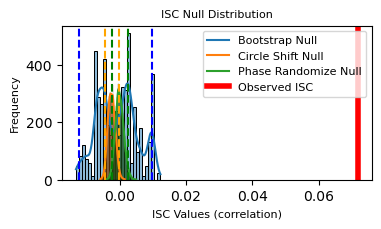

92
ISC: 0.051, p = 0.0002


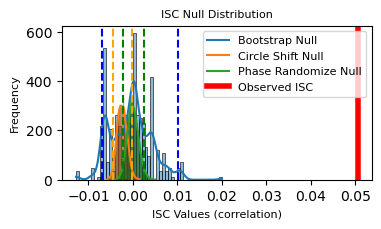

93
ISC: 0.067, p = 0.0002


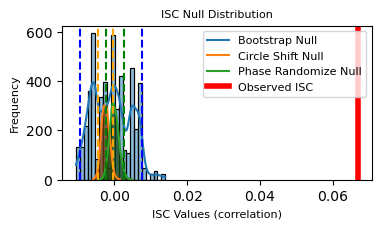

94
ISC: 0.18, p = 0.0002


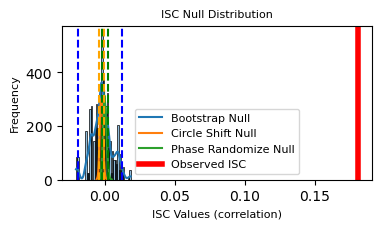

95
ISC: 0.056, p = 0.0002


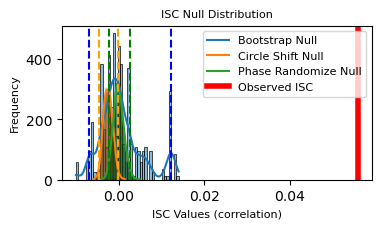

96
ISC: 0.048, p = 0.0002


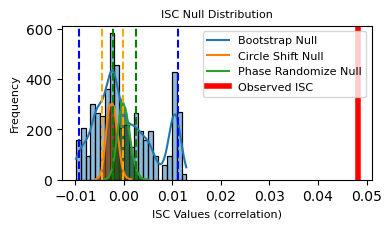

97
ISC: 0.24, p = 0.0002


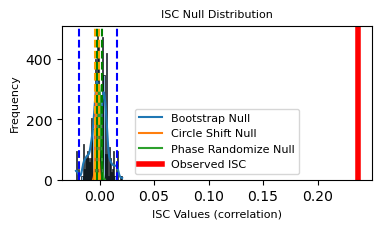

98
ISC: 0.092, p = 0.0002


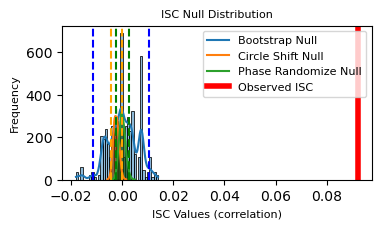

99
ISC: 0.1, p = 0.0002


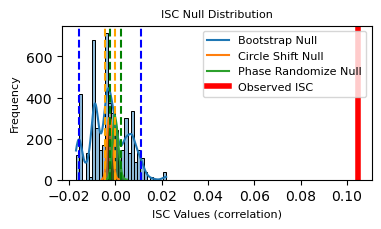

100
ISC: 0.036, p = 0.0002


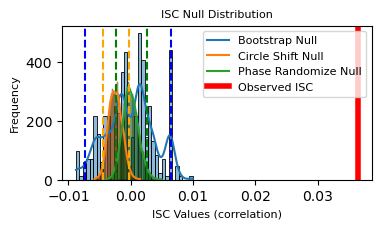

101
ISC: 0.072, p = 0.0002


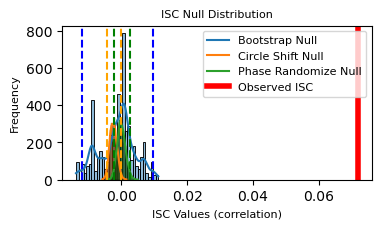

102
ISC: 0.029, p = 0.0002


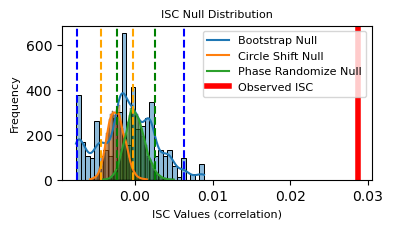

103
ISC: 0.044, p = 0.0002


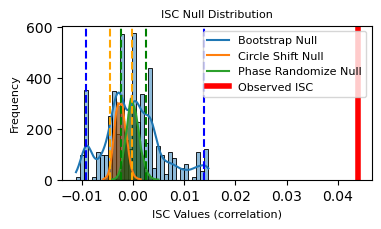

104
ISC: 0.067, p = 0.0002


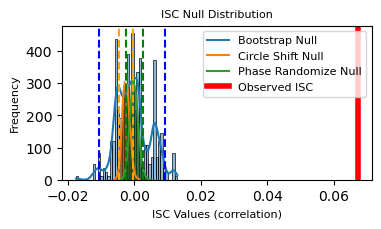

105
ISC: 0.064, p = 0.0002


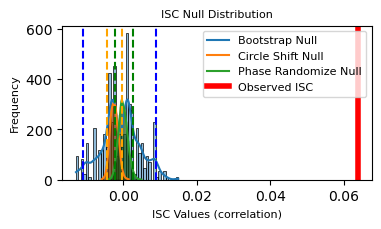

106
ISC: 0.038, p = 0.0002


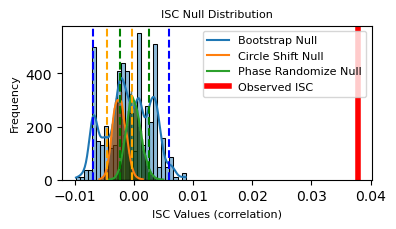

107
ISC: 0.085, p = 0.0002


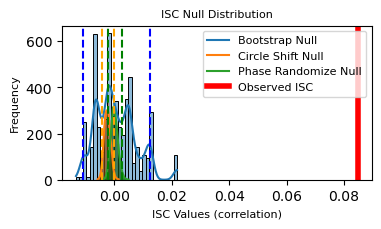

108
ISC: 0.11, p = 0.0002


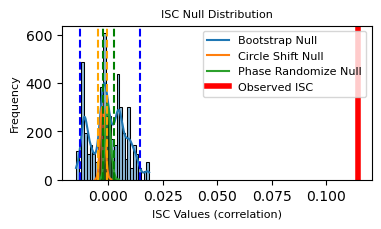

109
ISC: 0.04, p = 0.0002


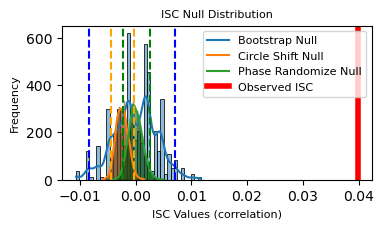

110
ISC: 0.1, p = 0.0002


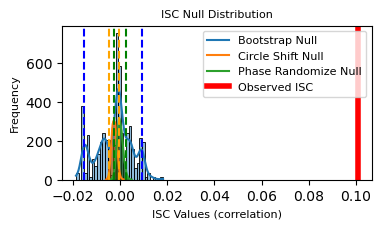

111
ISC: 0.17, p = 0.0002


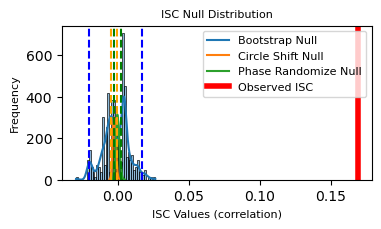

112
ISC: 0.063, p = 0.0002


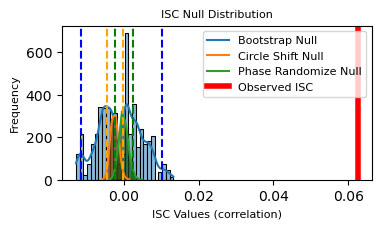

113
ISC: 0.086, p = 0.0002


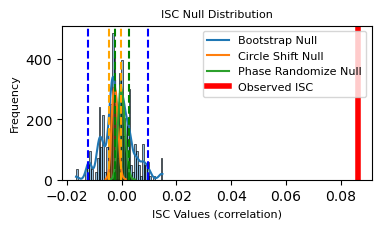

114
ISC: 0.08, p = 0.0002


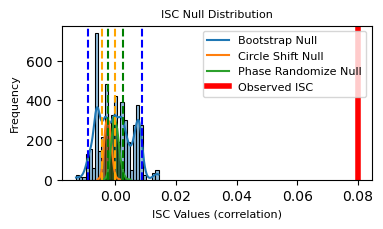

115
ISC: 0.067, p = 0.0002


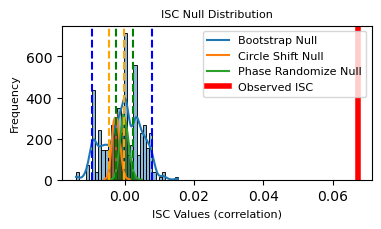

116
ISC: 0.06, p = 0.0002


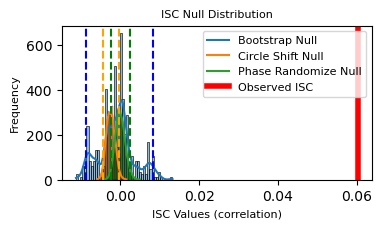

117
ISC: 0.078, p = 0.0002


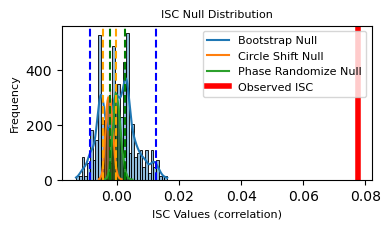

118
ISC: 0.053, p = 0.0002


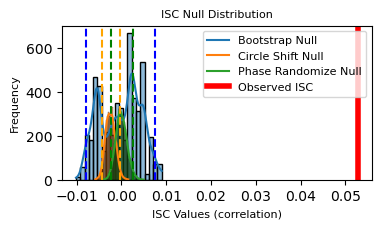

119
ISC: 0.1, p = 0.0002


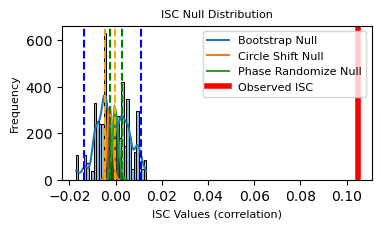

120
ISC: 0.043, p = 0.0002


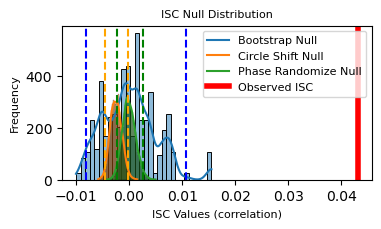

121
ISC: 0.075, p = 0.0002


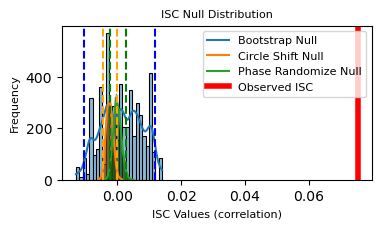

122
ISC: 0.045, p = 0.0002


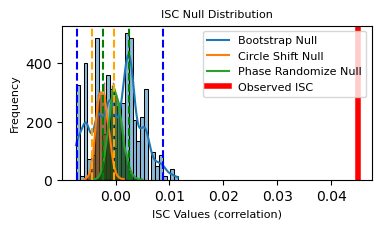

123
ISC: 0.057, p = 0.0002


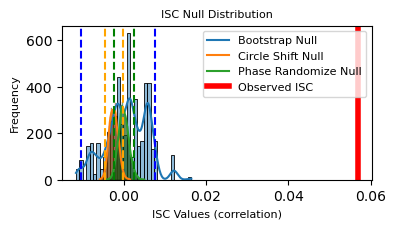

124
ISC: 0.03, p = 0.0002


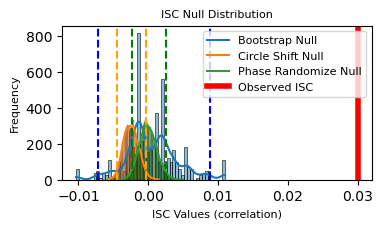

125
ISC: 0.065, p = 0.0002


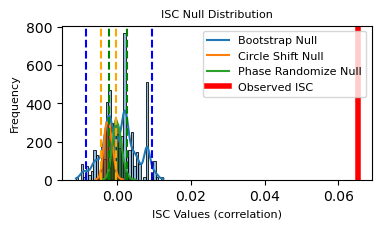

126
ISC: 0.038, p = 0.0002


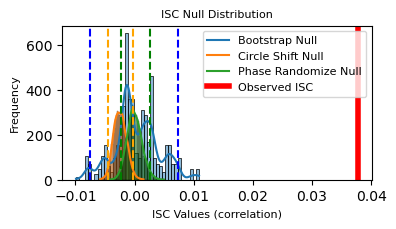

127
ISC: 0.068, p = 0.0002


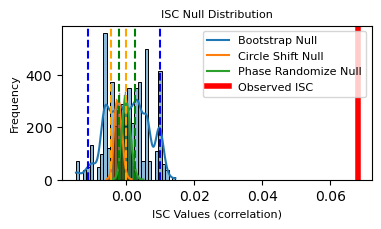

128
ISC: 0.025, p = 0.0002


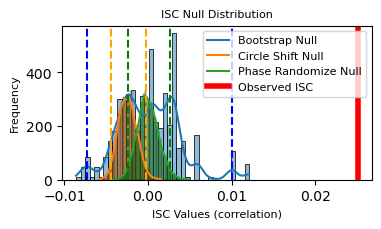

129
ISC: 0.015, p = 0.0002


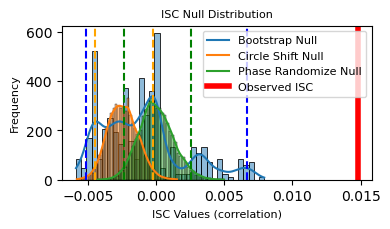

130
ISC: 0.0093, p = 0.0002


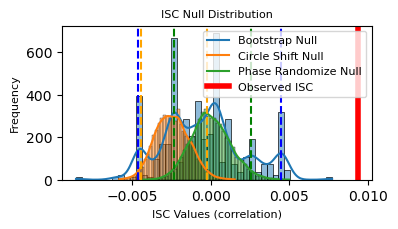

131
ISC: 0.034, p = 0.0002


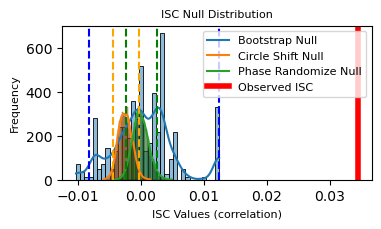

132
ISC: 0.012, p = 0.0002


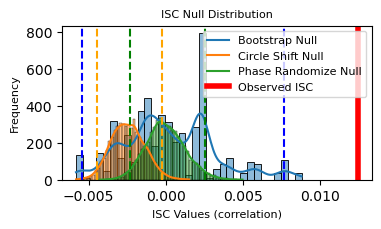

133
ISC: 0.095, p = 0.0002


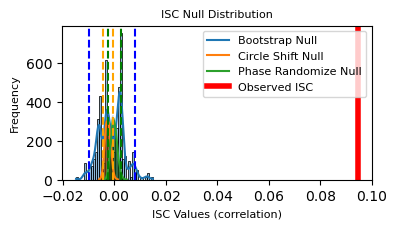

134
ISC: 0.042, p = 0.0002


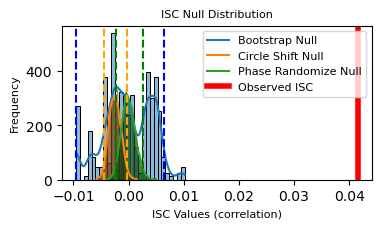

135
ISC: 0.066, p = 0.0002


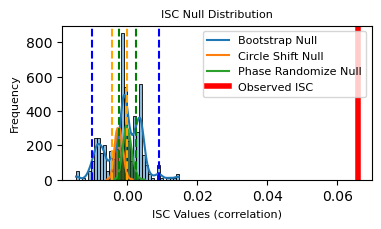

136
ISC: 0.09, p = 0.0002


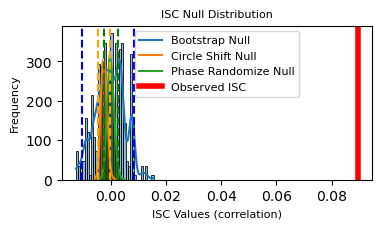

137
ISC: 0.12, p = 0.0002


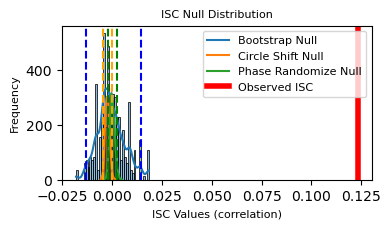

138
ISC: 0.063, p = 0.0002


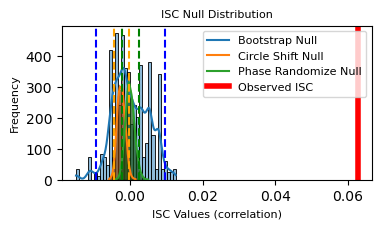

139
ISC: 0.098, p = 0.0002


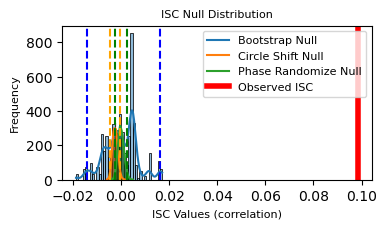

140
ISC: 0.12, p = 0.0002


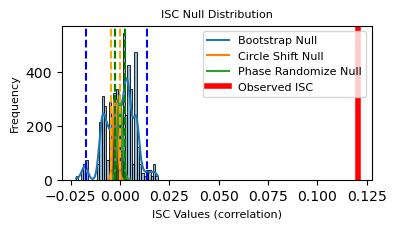

141
ISC: 0.12, p = 0.0002


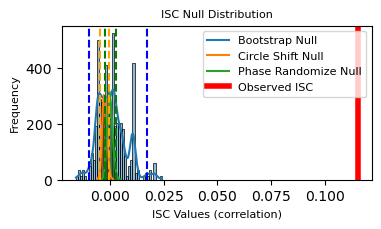

142
ISC: 0.11, p = 0.0002


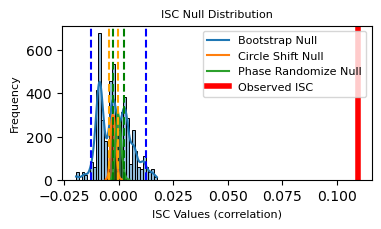

143
ISC: 0.095, p = 0.0002


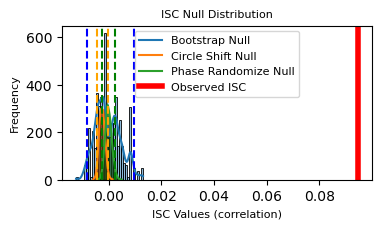

144
ISC: 0.12, p = 0.0002


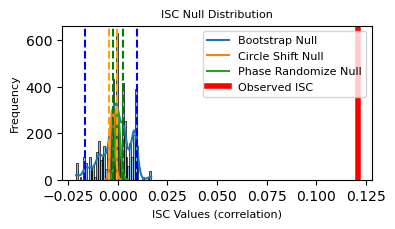

145
ISC: 0.13, p = 0.0002


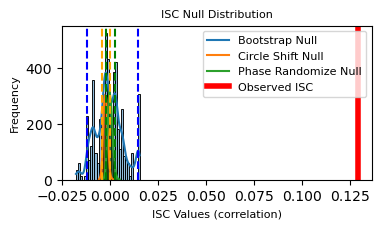

146
ISC: 0.13, p = 0.0002


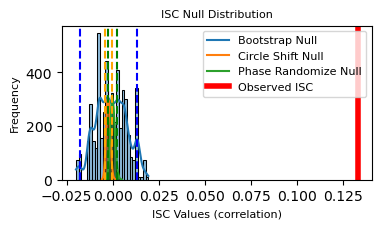

147
ISC: 0.11, p = 0.0002


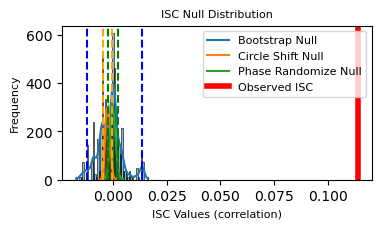

148
ISC: 0.13, p = 0.0002


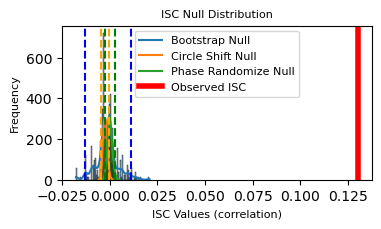

149
ISC: 0.057, p = 0.0002


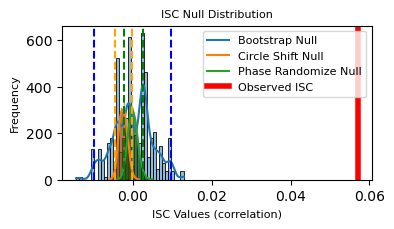

150
ISC: 0.083, p = 0.0002


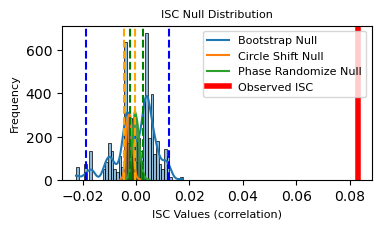

151
ISC: 0.083, p = 0.0002


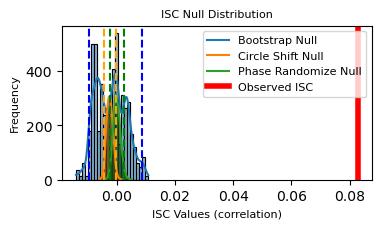

152
ISC: 0.085, p = 0.0002


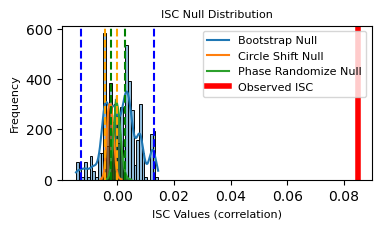

153
ISC: 0.14, p = 0.0002


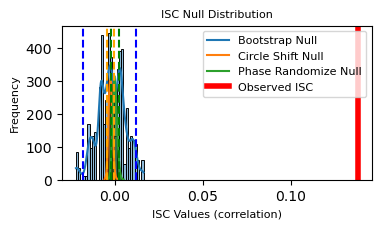

154
ISC: 0.11, p = 0.0002


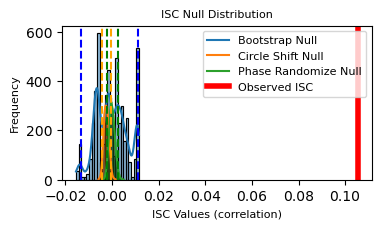

155
ISC: 0.098, p = 0.0002


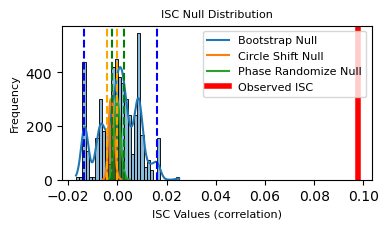

156
ISC: 0.2, p = 0.0002


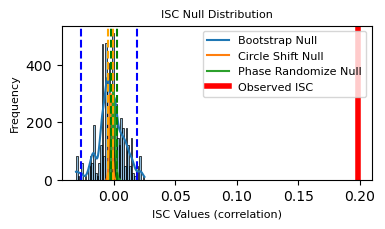

157
ISC: 0.078, p = 0.0002


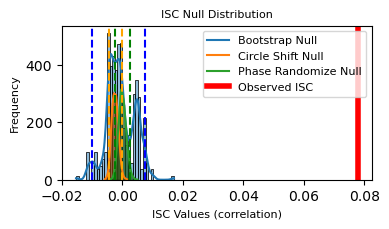

158
ISC: 0.03, p = 0.0002


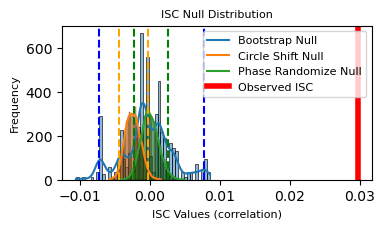

159
ISC: 0.055, p = 0.0002


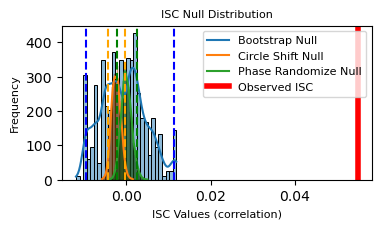

160
ISC: 0.073, p = 0.0002


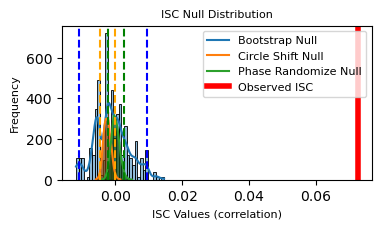

161
ISC: 0.065, p = 0.0002


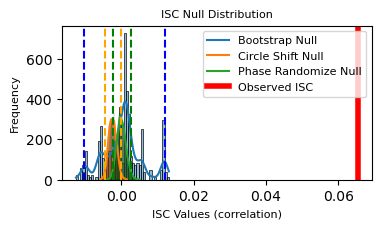

162
ISC: 0.12, p = 0.0002


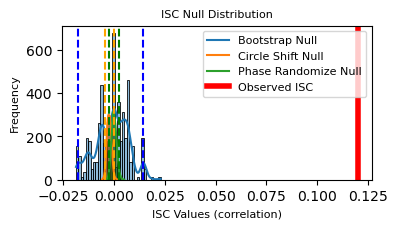

163
ISC: 0.15, p = 0.0002


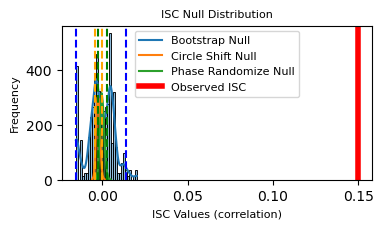

164
ISC: 0.095, p = 0.0002


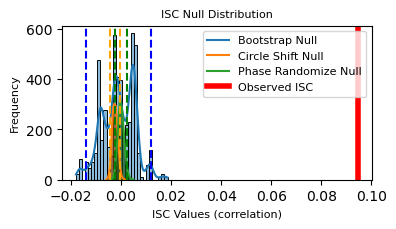

165
ISC: 0.21, p = 0.0002


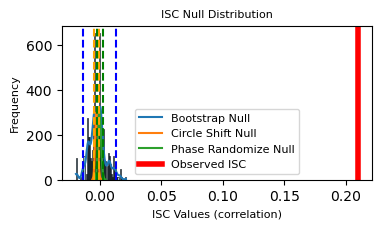

166
ISC: 0.071, p = 0.0002


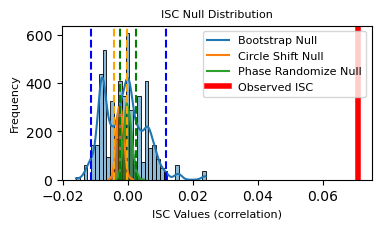

167
ISC: 0.2, p = 0.0002


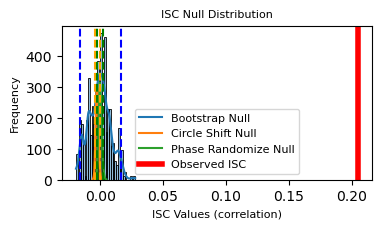

168
ISC: 0.14, p = 0.0002


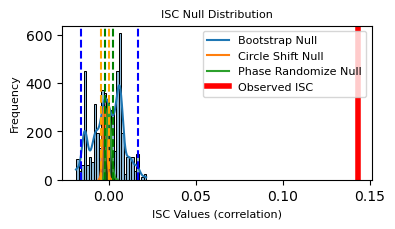

169
ISC: 0.12, p = 0.0002


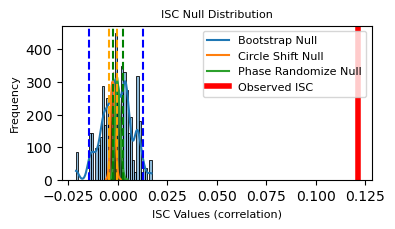

170
ISC: 0.3, p = 0.0002


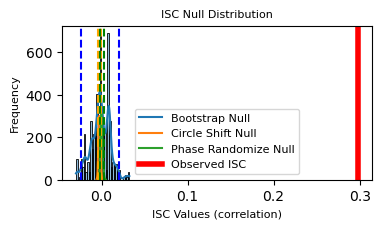

171
ISC: 0.094, p = 0.0002


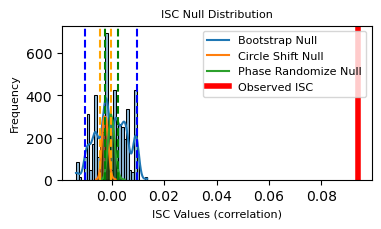

172
ISC: 0.057, p = 0.0002


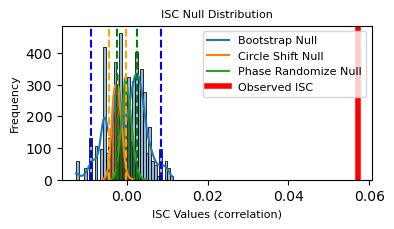

173
ISC: 0.082, p = 0.0002


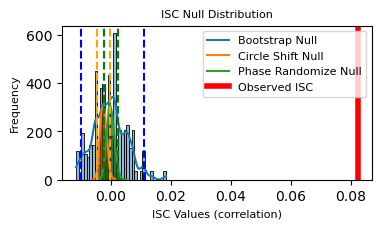

174
ISC: 0.21, p = 0.0002


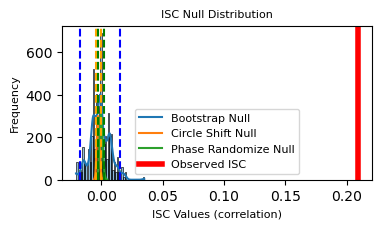

175
ISC: 0.31, p = 0.0002


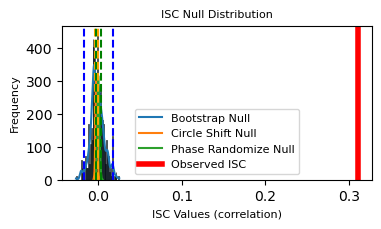

176
ISC: 0.18, p = 0.0002


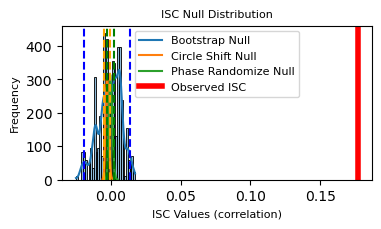

177
ISC: 0.24, p = 0.0002


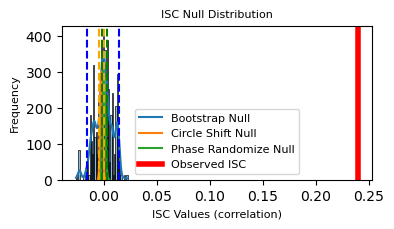

178
ISC: 0.32, p = 0.0002


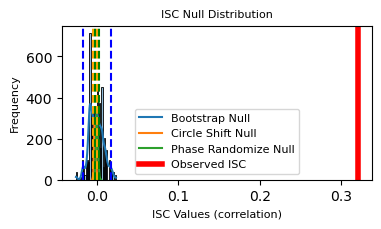

179
ISC: 0.11, p = 0.0002


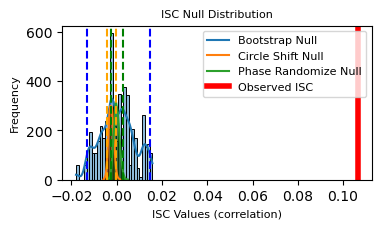

180
ISC: 0.32, p = 0.0002


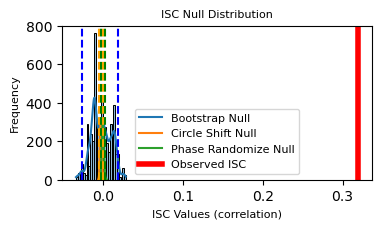

181
ISC: 0.22, p = 0.0002


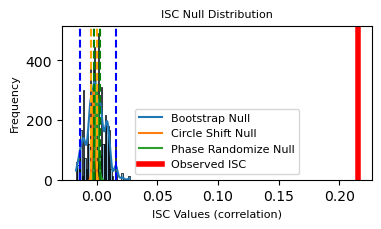

182
ISC: 0.21, p = 0.0002


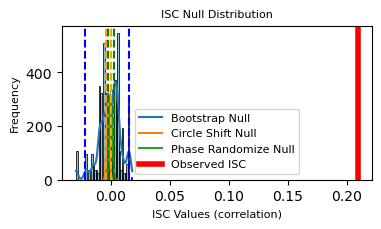

183
ISC: 0.22, p = 0.0002


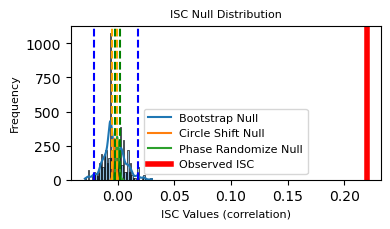

184
ISC: 0.071, p = 0.0002


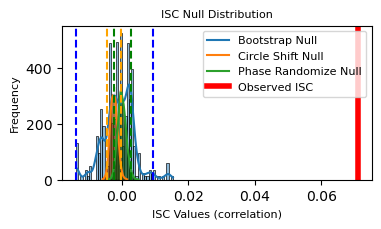

185
ISC: 0.086, p = 0.0002


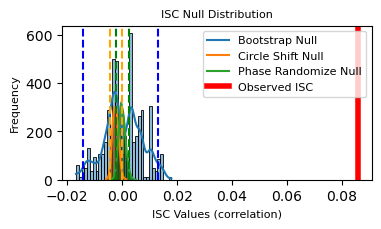

186
ISC: 0.16, p = 0.0002


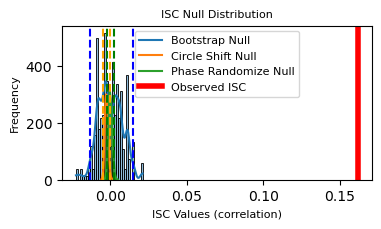

187
ISC: 0.056, p = 0.0002


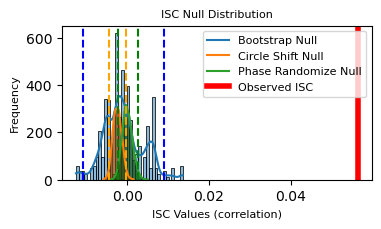

188
ISC: 0.0029, p = 0.264


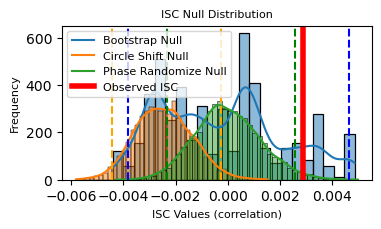

189
ISC: 0.17, p = 0.0002


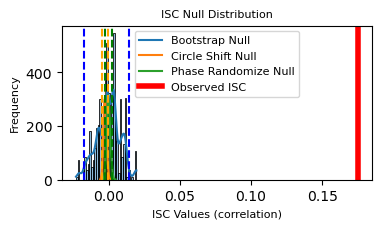

190
ISC: 0.094, p = 0.0002


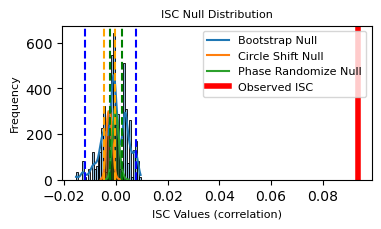

191
ISC: 0.14, p = 0.0002


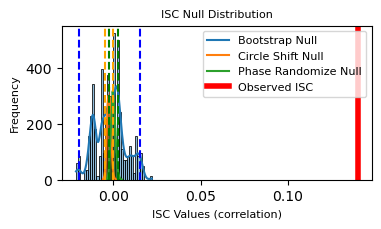

192
ISC: 0.12, p = 0.0002


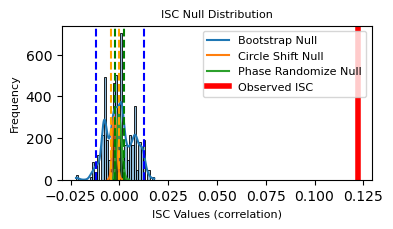

193
ISC: 0.058, p = 0.0002


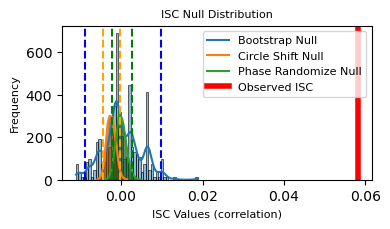

194
ISC: 0.066, p = 0.0002


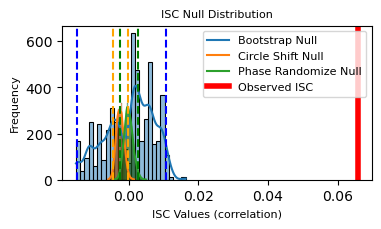

195
ISC: 0.046, p = 0.0002


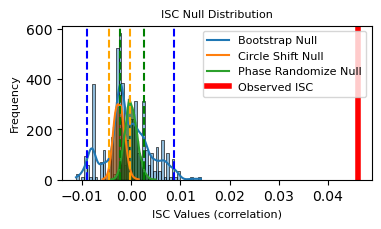

196
ISC: 0.12, p = 0.0002


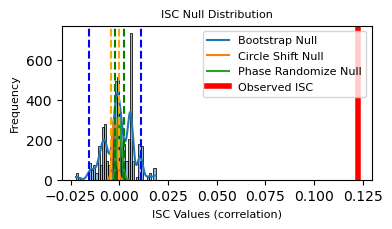

197
ISC: 0.25, p = 0.0002


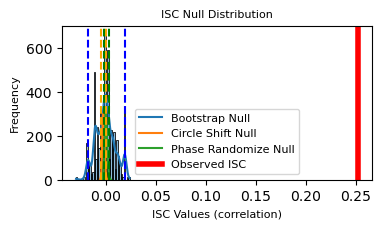

198
ISC: 0.14, p = 0.0002


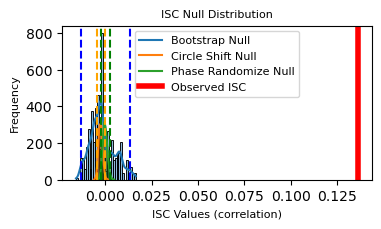

199
ISC: 0.27, p = 0.0002


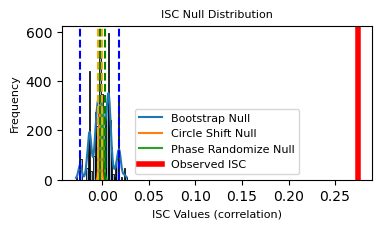

200
ISC: 0.16, p = 0.0002


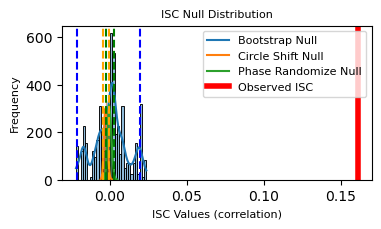

201
ISC: 0.017, p = 0.0002


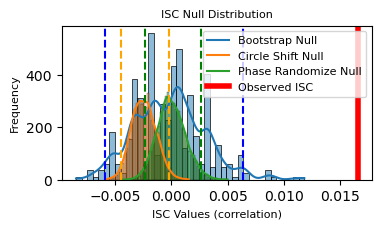

202
ISC: 0.26, p = 0.0002


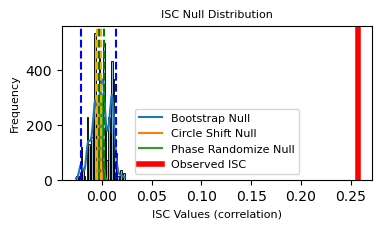

203
ISC: 0.27, p = 0.0002


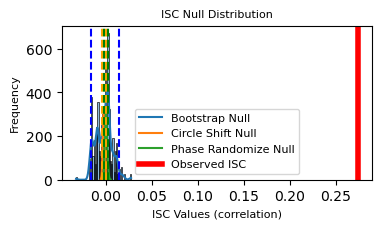

204
ISC: 0.21, p = 0.0002


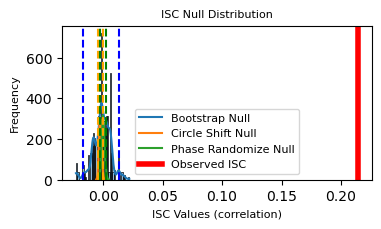

205
ISC: 0.28, p = 0.0002


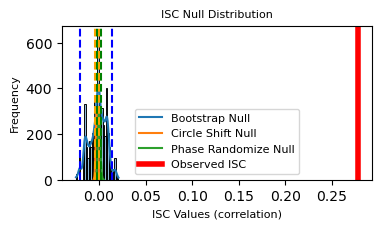

206
ISC: 0.31, p = 0.0002


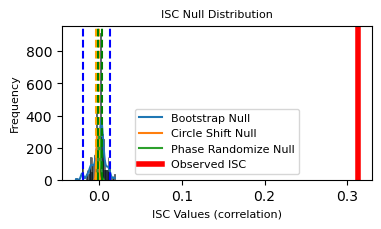

207
ISC: 0.23, p = 0.0002


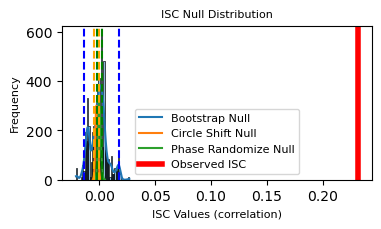

208
ISC: 0.36, p = 0.0002


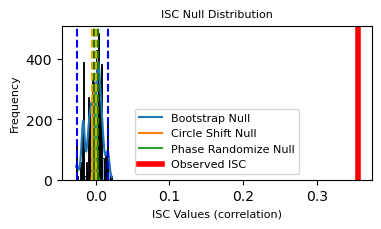

209
ISC: 0.25, p = 0.0002


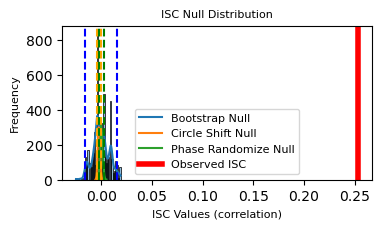

210
ISC: 0.26, p = 0.0002


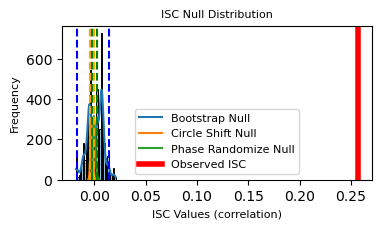

211
ISC: 0.32, p = 0.0002


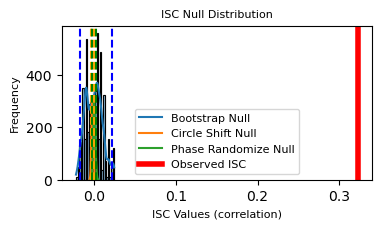

212
ISC: 0.34, p = 0.0002


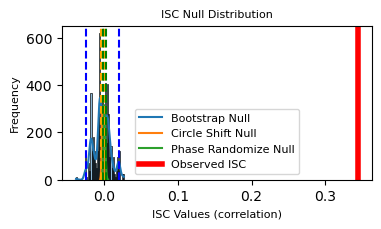

213
ISC: 0.27, p = 0.0002


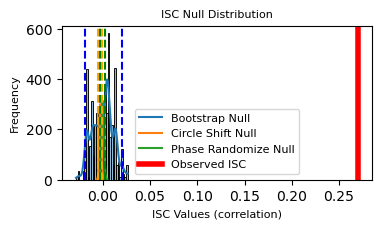

214
ISC: 0.25, p = 0.0002


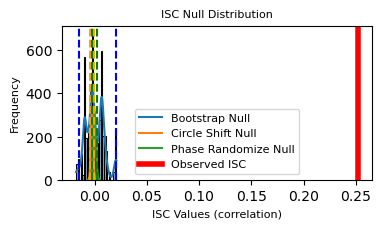

215
ISC: 0.21, p = 0.0002


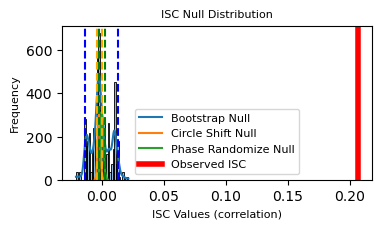

216
ISC: 0.1, p = 0.0002


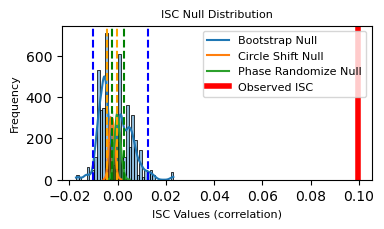

217
ISC: 0.1, p = 0.0002


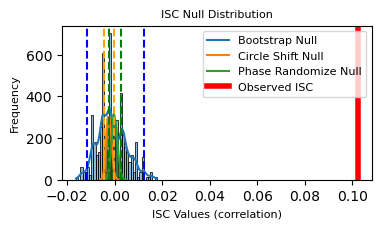

218
ISC: 0.061, p = 0.0002


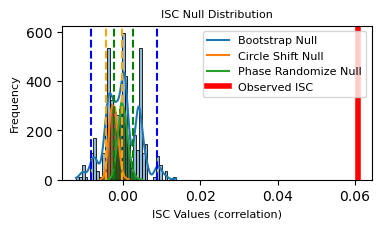

219
ISC: 0.046, p = 0.0002


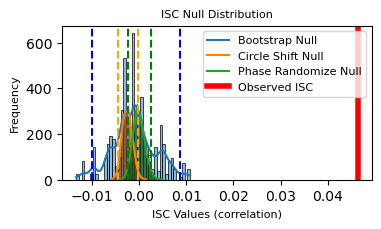

220
ISC: 0.074, p = 0.0002


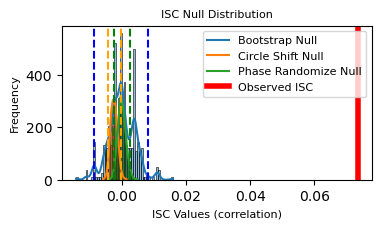

221
ISC: 0.26, p = 0.0002


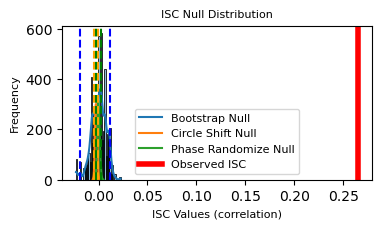

222
ISC: 0.2, p = 0.0002


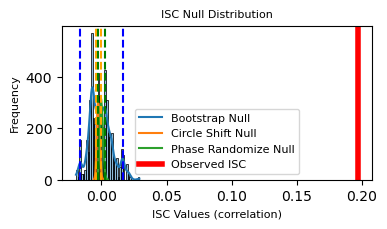

223
ISC: 0.13, p = 0.0002


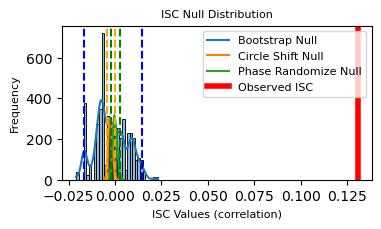

224
ISC: 0.31, p = 0.0002


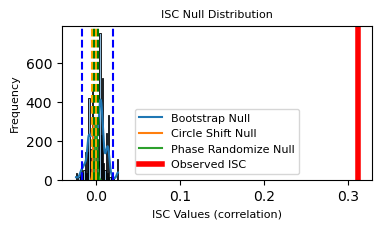

225
ISC: 0.22, p = 0.0002


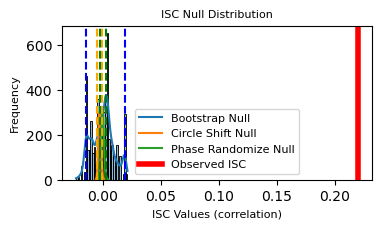

226
ISC: 0.14, p = 0.0002


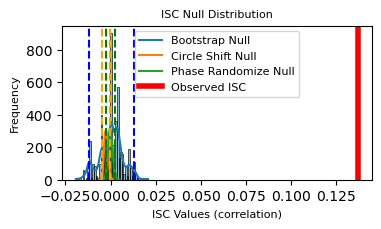

227
ISC: 0.064, p = 0.0002


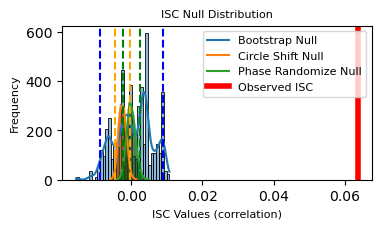

228
ISC: 0.03, p = 0.0002


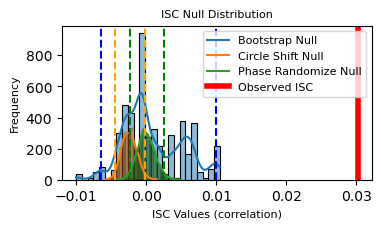

229
ISC: 0.17, p = 0.0002


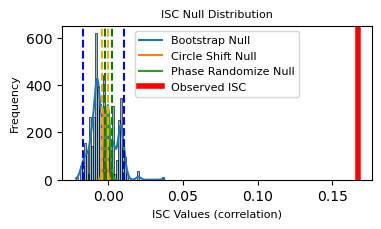

230
ISC: 0.087, p = 0.0002


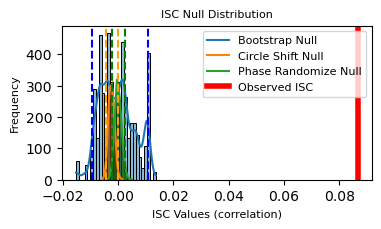

231
ISC: 0.055, p = 0.0002


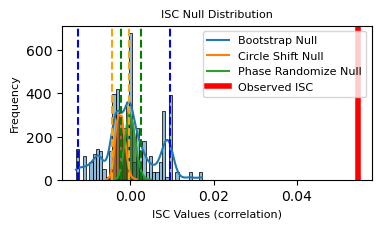

232
ISC: 0.09, p = 0.0002


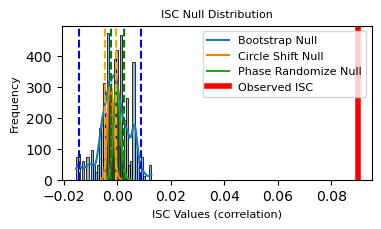

233
ISC: 0.058, p = 0.0002


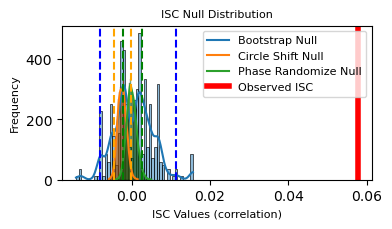

234
ISC: 0.016, p = 0.0002


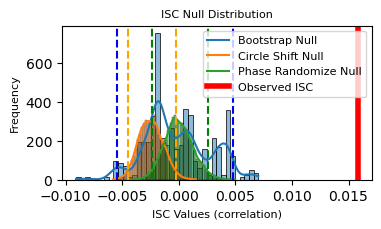

235
ISC: 0.064, p = 0.0002


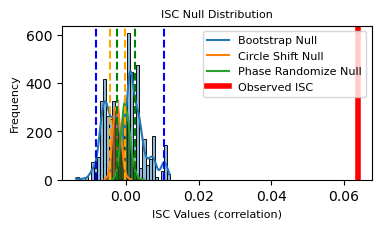

236
ISC: 0.086, p = 0.0002


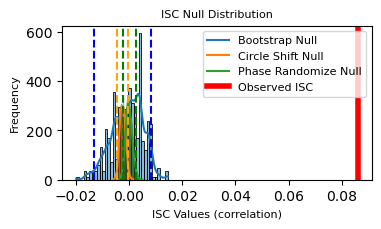

237
ISC: 0.13, p = 0.0002


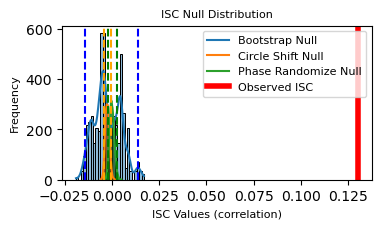

238
ISC: 0.082, p = 0.0002


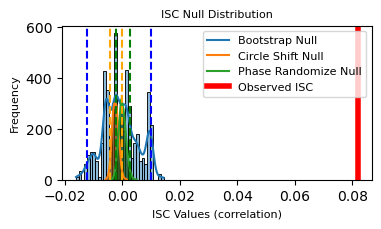

239
ISC: 0.2, p = 0.0002


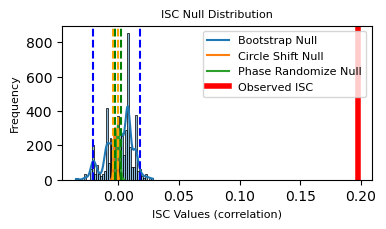

240
ISC: 0.066, p = 0.0002


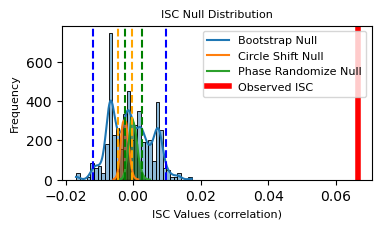

241
ISC: 0.11, p = 0.0002


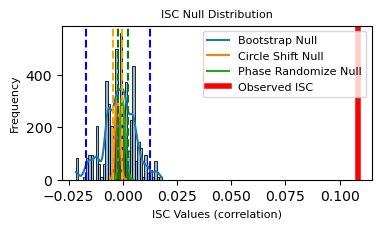

242
ISC: 0.082, p = 0.0002


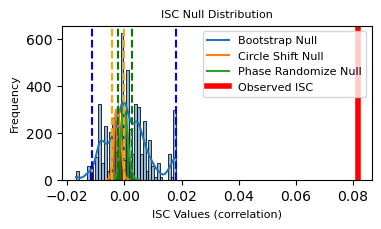

243
ISC: 0.032, p = 0.0002


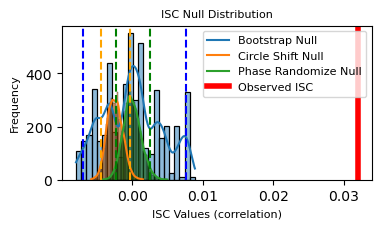

244
ISC: 0.042, p = 0.0002


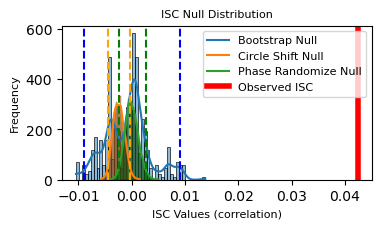

245
ISC: 0.067, p = 0.0002


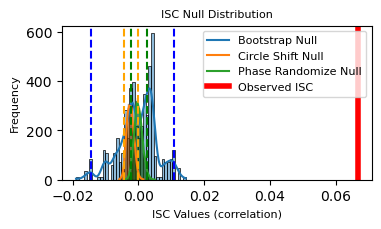

246
ISC: 0.1, p = 0.0002


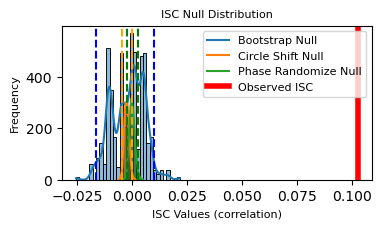

247
ISC: 0.064, p = 0.0002


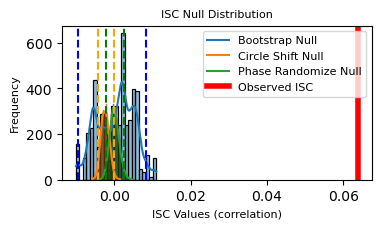

248
ISC: 0.13, p = 0.0002


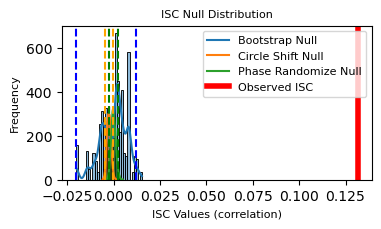

249
ISC: 0.12, p = 0.0002


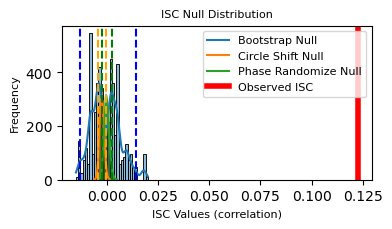

250
ISC: 0.019, p = 0.0002


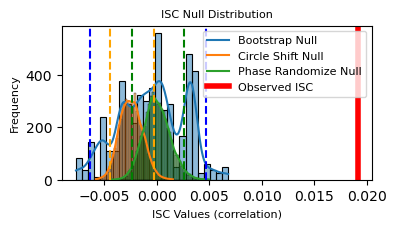

251
ISC: 0.07, p = 0.0002


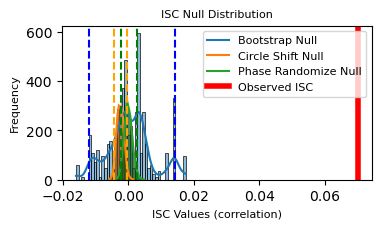

252
ISC: 0.1, p = 0.0002


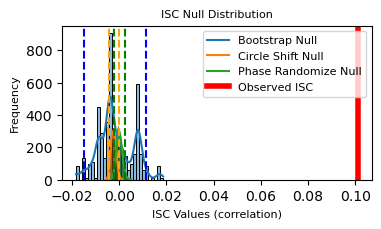

253
ISC: 0.041, p = 0.0002


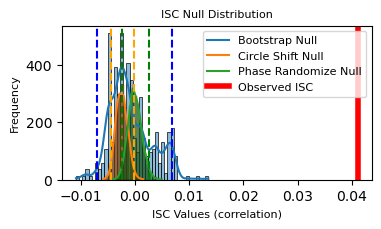

254
ISC: 0.027, p = 0.0002


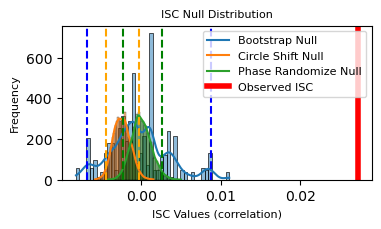

255
ISC: 0.056, p = 0.0002


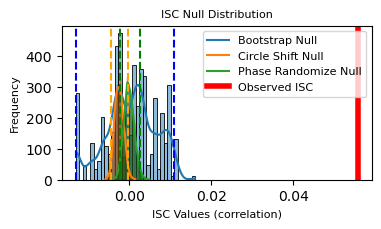

256
ISC: 0.021, p = 0.0002


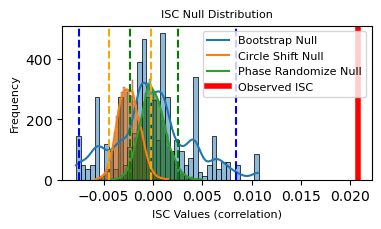

257
ISC: 0.052, p = 0.0002


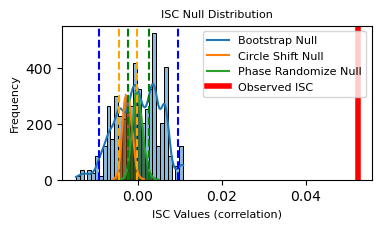

258
ISC: 0.036, p = 0.0002


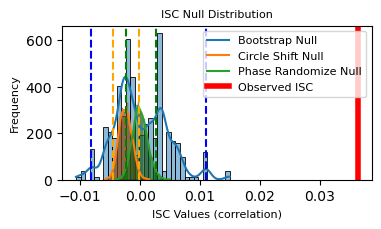

259
ISC: 0.038, p = 0.0002


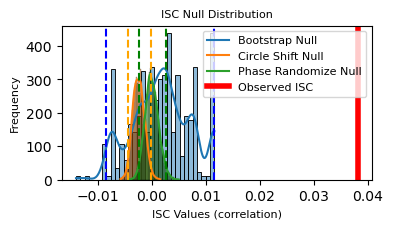

260
ISC: 0.057, p = 0.0002


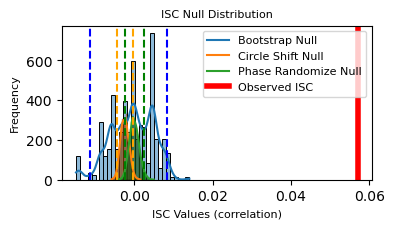

261
ISC: 0.06, p = 0.0002


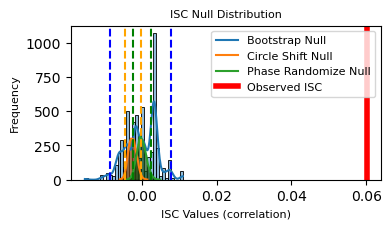

262
ISC: 0.06, p = 0.0002


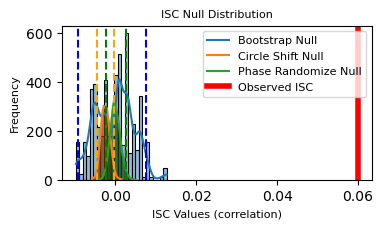

263
ISC: 0.034, p = 0.0002


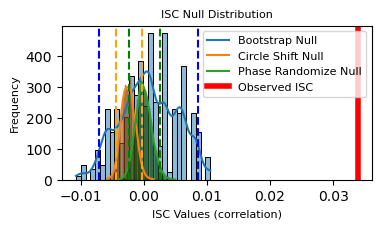

264
ISC: 0.028, p = 0.0002


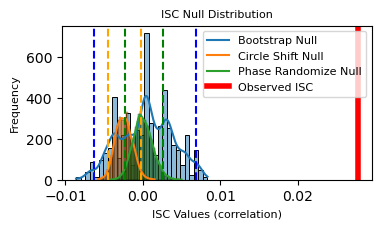

265
ISC: 0.024, p = 0.0002


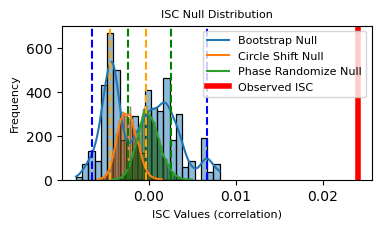

266
ISC: 0.012, p = 0.0002


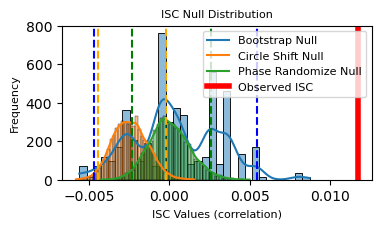

267
ISC: 0.0099, p = 0.0026


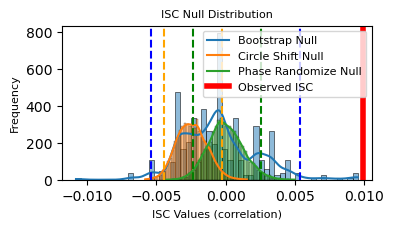

268
ISC: 0.084, p = 0.0002


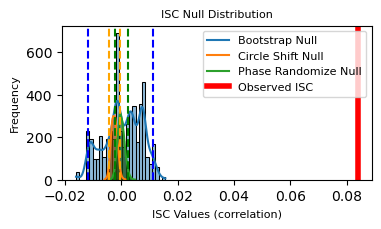

269
ISC: 0.069, p = 0.0002


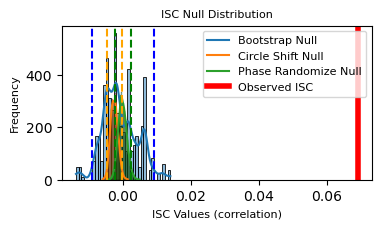

270
ISC: 0.03, p = 0.0002


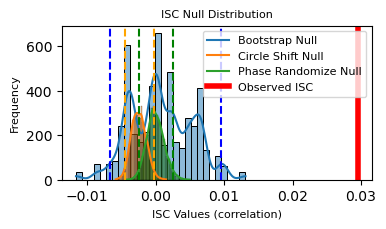

271
ISC: 0.064, p = 0.0002


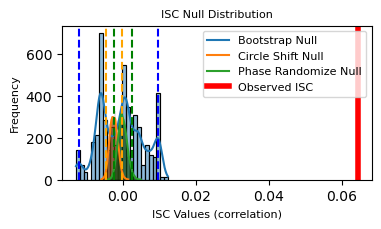

272
ISC: 0.026, p = 0.0002


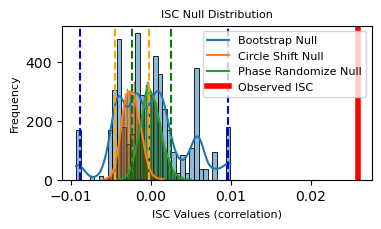

273
ISC: 0.012, p = 0.0002


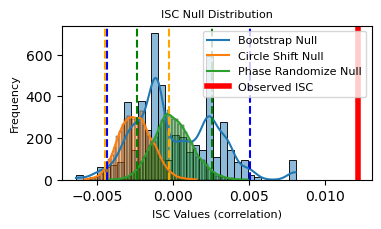

274
ISC: 0.017, p = 0.0002


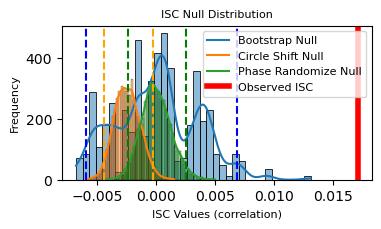

275
ISC: 0.023, p = 0.0002


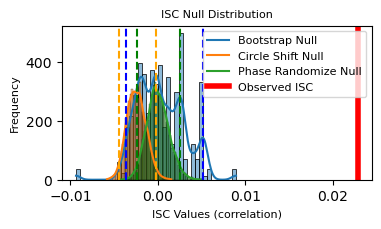

276
ISC: 0.024, p = 0.0002


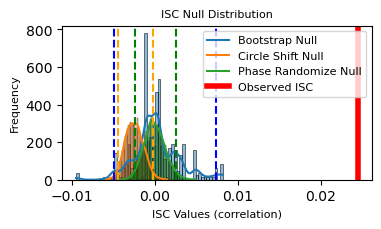

277
ISC: 0.0099, p = 0.0002


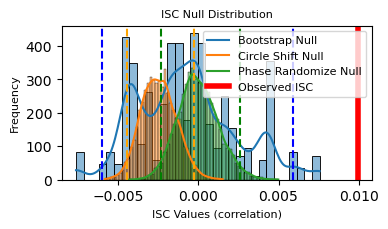

278
ISC: 0.019, p = 0.0002


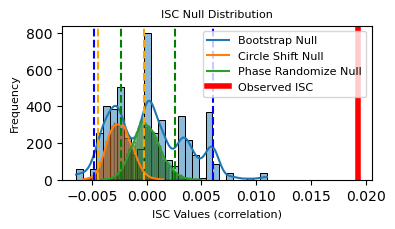

279
ISC: 0.06, p = 0.0002


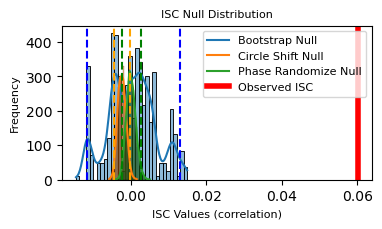

280
ISC: 0.0074, p = 0.0026


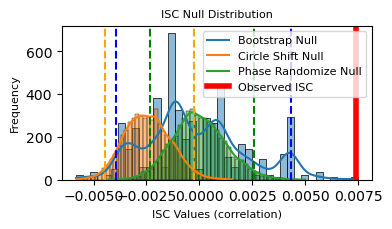

281
ISC: 0.02, p = 0.0002


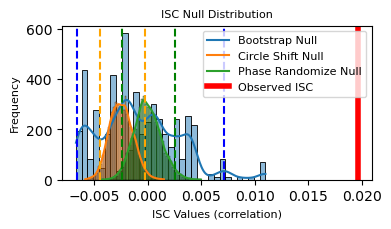

282
ISC: 0.0055, p = 0.071


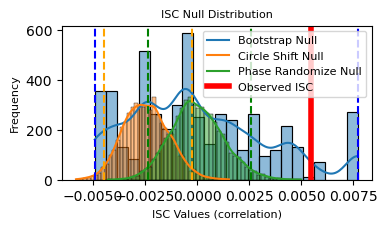

283
ISC: 0.0053, p = 0.029


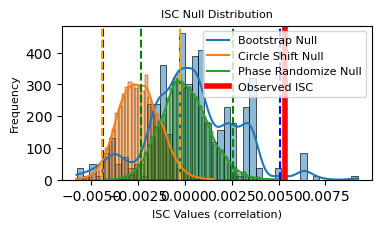

284
ISC: 0.015, p = 0.0002


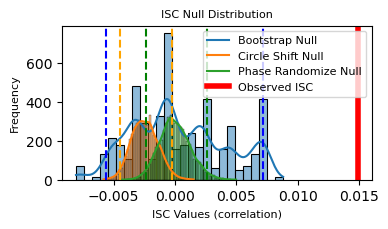

285
ISC: 0.0025, p = 0.115


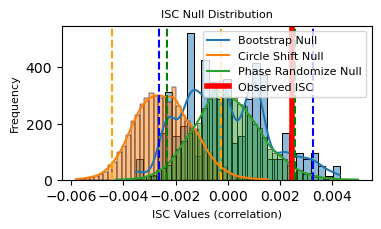

286
ISC: 0.017, p = 0.0002


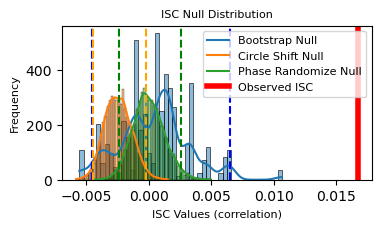

287
ISC: 0.013, p = 0.0002


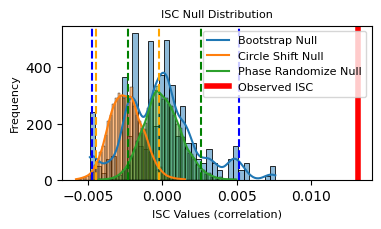

288
ISC: 0.0078, p = 0.0002


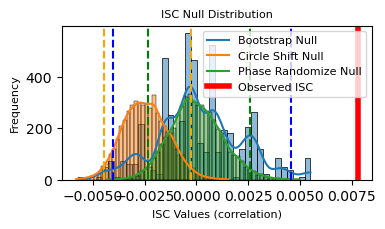

289
ISC: 0.016, p = 0.0002


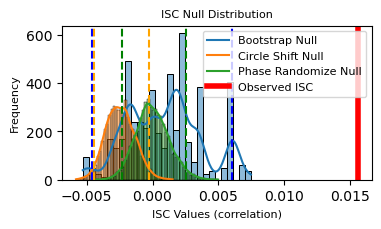

290
ISC: 0.015, p = 0.0002


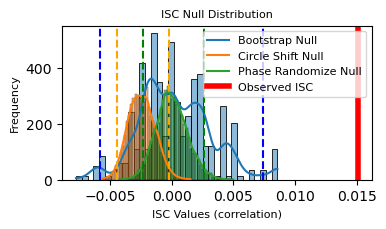

291
ISC: 0.008, p = 0.0002


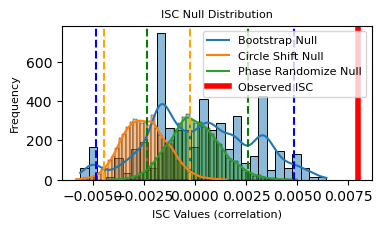

292
ISC: 0.012, p = 0.0002


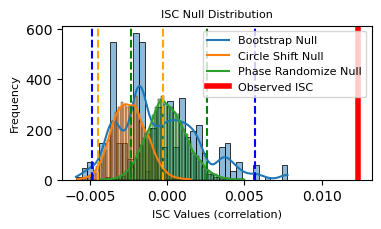

In [68]:

p_results = []
isc_results = []

for curr_roi in range(293):
    print(curr_roi)
    data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )
    stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True)
    print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
    p_results.append(stats_boot['p'])
    isc_results.append(stats_boot['isc'])


    fs = 8
    plt.figure(figsize=(4,2));
    sns.histplot(stats_boot['null_distribution'] - stats_boot['isc'], kde=True, label='Bootstrap');
    sns.histplot(stats_circle['null_distribution'], kde=True, label='Bootstrap');
    sns.histplot(stats_phase['null_distribution'], kde=True, label='Bootstrap');
    plt.ylabel('Frequency', fontsize= fs);
    plt.xlabel('ISC Values (correlation)', fontsize= fs);
    plt.title('ISC Null Distribution', fontsize= fs);
    plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4);
    plt.legend(['Bootstrap Null','Circle Shift Null', 'Phase Randomize Null', 'Observed ISC'], fontsize=fs);
    
    plt.axvline(stats_boot['ci'][0] - stats_boot['isc'], linestyle='--', color='blue');
    plt.axvline(stats_boot['ci'][1] - stats_boot['isc'], linestyle='--', color='blue');
    
    plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange');
    plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange');
    
    plt.axvline(stats_phase['ci'][0], linestyle='--', color='green');
    plt.axvline(stats_phase['ci'][1], linestyle='--', color='green');
    plt.show()

In [16]:
from surfplot import Plot
from neuromaps.datasets import fetch_fslr
from neuromaps.transforms import mni152_to_fslr


#import os
#os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
#os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')





# Fetch fsLR surfaces from neuromaps
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
sulc_lh, sulc_rh = surfaces['sulc']

# Convert volumetric MNI data to fsLR surface
gii_lh, gii_rh = mni152_to_fslr(nilearn.image.smooth_img(result_image, 4), method='linear')

# Plot example ROI on surface
p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='hot', color_range=(0, 0.4))
cbar_kws = dict(location='right', draw_border=False, aspect=3,
                shrink=.2, decimals=0, pad=0, n_ticks=2)
fig = p.build(cbar_kws=cbar_kws)